<a href="https://colab.research.google.com/github/dassus98/banking_churn/blob/main/Banking_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [9]:
# Standard Library & Utilities
import pandas as pd
import numpy as np
import warnings
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (Scikit-Learn)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, f1_score, precision_recall_curve
)

# Advanced Models & Sampling
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Crucial for SMOTE in pipelines

# Configuration & Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.float_format', '{:.2f}'.format) # Clean decimals

# Warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data Preparation

In [10]:
# Loading data
df = pd.read_csv('banking_churn.csv', header=0)

# Inspecting data
print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')

# Dropping irrelevant columns
drop_cols = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(columns = drop_cols)

# Defining features
X = df.drop(columns = ['Exited'])
y = df['Exited']

# Splitting features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2, 
    random_state = RANDOM_SEED, 
    stratify = y
    )

Shape: (10000, 14)
Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


# Feature Engineering

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

# Defining custom transformer for feature engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Interaction feature: Wealth per product
        # Exploring whether high savings + few products = saver
        # Differentiates passive savers from active product users
        X['BalancePerProduct'] = X['Balance'] / X['NumOfProducts']

        # Interaction feature: Tenure / Age Ratio
        # Exploring whether young customers + high tenure = loyal customer base
        X['TenureAgeRatio'] = X['Tenure'] / X['Age']

        # Interaction feature: Is Senior
        # Binning age to help tree models
        X['IsSenior'] = (X['Age'] > 60).astype(int)

        return X
    
# Defining lists of columns
numeric_features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 
    'BalancePerProduct', 'TenureAgeRatio'
]

categorical_features = [
    'Geography', 'Gender'
]

# Creating column transformer
preprocessor = ColumnTransformer(
    transformers = [
        # Scaling numeric values to help with convergence (important for SVM)
        ('num', StandardScaler(), numeric_features),

        # One-hot encoding categorical features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out = False
)

print("Preprocessing Pipeline Completed.")

Preprocessing Pipeline Completed.


# Developing Basic Pipeline with XGBoost and SMOTE

In [18]:
# Building final pipeline
model_pipeline = ImbPipeline(steps = [
    # Creating new features
    ('feature_engineering', FeatureEngineer()),

    # Transform data
    ('preprocessor', preprocessor),
    
    # Use SMOTE to handle class imbalance
    ('smote', SMOTE(random_state=RANDOM_SEED)),

    # XGBoost
    ('classifier', XGBClassifier(
        n_estimators = 100,
        learning_rate = 0.1,
        max_depth = 4,
        random_state = RANDOM_SEED,
        n_jobs = -1,
        eval_metric = 'logloss'
    ))
])

print('Model Pipeline Completed.')

Model Pipeline Completed.


# Training & Evaluating the XGBoost Classifier

Model training in process...

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1593
           1       0.57      0.64      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.83      2000


Confusion Matrix


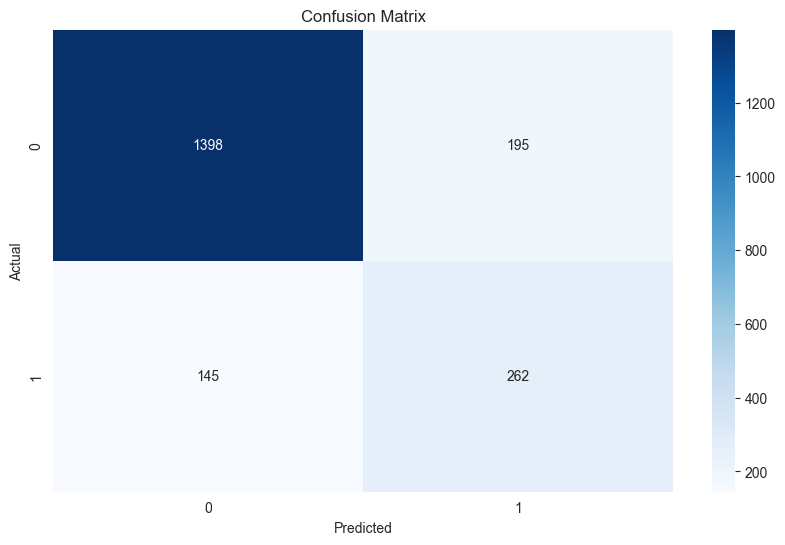

In [21]:
print('Model training in process...')
model_pipeline.fit(X_train, y_train)

# Predicting outcomes
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

# Printing metrics
print('\nClassification Report')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix')
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Evaluating Real-World Business Consequences

In [22]:
# Calculating business impact of churn
# Let's assume that the retention cost is $250 and the churn cost is $5000
# So it costs 5% of the churn to try and retain a customer

tn, fp, fn, tp = conf_matrix.ravel()

# Churn Cost if we take no action to prevent customer loss
cost_do_nothing = (fn + tp) * 5000

# Adding up the Retention Cost + Missed Opportunities + Churn Cost
cost_model = (fp * 250) + (tp * 250) + (fn * 5000)

savings = cost_do_nothing - cost_model

print(f'\nROI Analysis')
print(f'Cost of Inaction: ${cost_do_nothing:,.0f}')
print(f'Cost of Retention: ${cost_model:,.0f}')
print(f'Savings: ${savings:,.0f}')


ROI Analysis
Cost of Inaction: $2,035,000
Cost of Retention: $839,250
Savings: $1,195,750


In [24]:

print(f'\nROI Analysis')
print(f'Cost of Inaction: ${cost_do_nothing:,.0f}')
print(f'Cost of Retention: ${cost_model:,.0f}')
print(f'Savings: ${savings:,.0f}')


ROI Analysis
Cost of Inaction: $2,035,000
Cost of Retention: $839,250
Savings: $1,195,750


# WARNING: IGNORE ANYTHING BELOW THIS
# WARNING: IGNORE ANYTHING BELOW THIS
# WARNING: IGNORE ANYTHING BELOW THIS

# Exploratory Data Analysis

## Color Palette

In [16]:
# Setting a default colour palette.

sequential_colors = sns.color_palette("Purples", 10)
sequential_colors

[(0.951449442522107, 0.9446981930026913, 0.969519415609381),
 (0.9007612456747405, 0.8963936947327951, 0.9434063821607074),
 (0.8355247981545559, 0.8361707035755478, 0.9118800461361014),
 (0.7469434832756633, 0.7505420991926183, 0.8675893886966551),
 (0.6620530565167244, 0.653440984236832, 0.8126105344098424),
 (0.5771626297577854, 0.5628911956939638, 0.7645059592464436),
 (0.4948558246828143, 0.47598615916955017, 0.7219838523644752),
 (0.4298961937716263, 0.3460668973471741, 0.6540715109573241),
 (0.36764321414840445, 0.22592848904267587, 0.5955401768550557),
 (0.30648212226066895, 0.11035755478662054, 0.5411303344867359)]

## Univariate Analysis

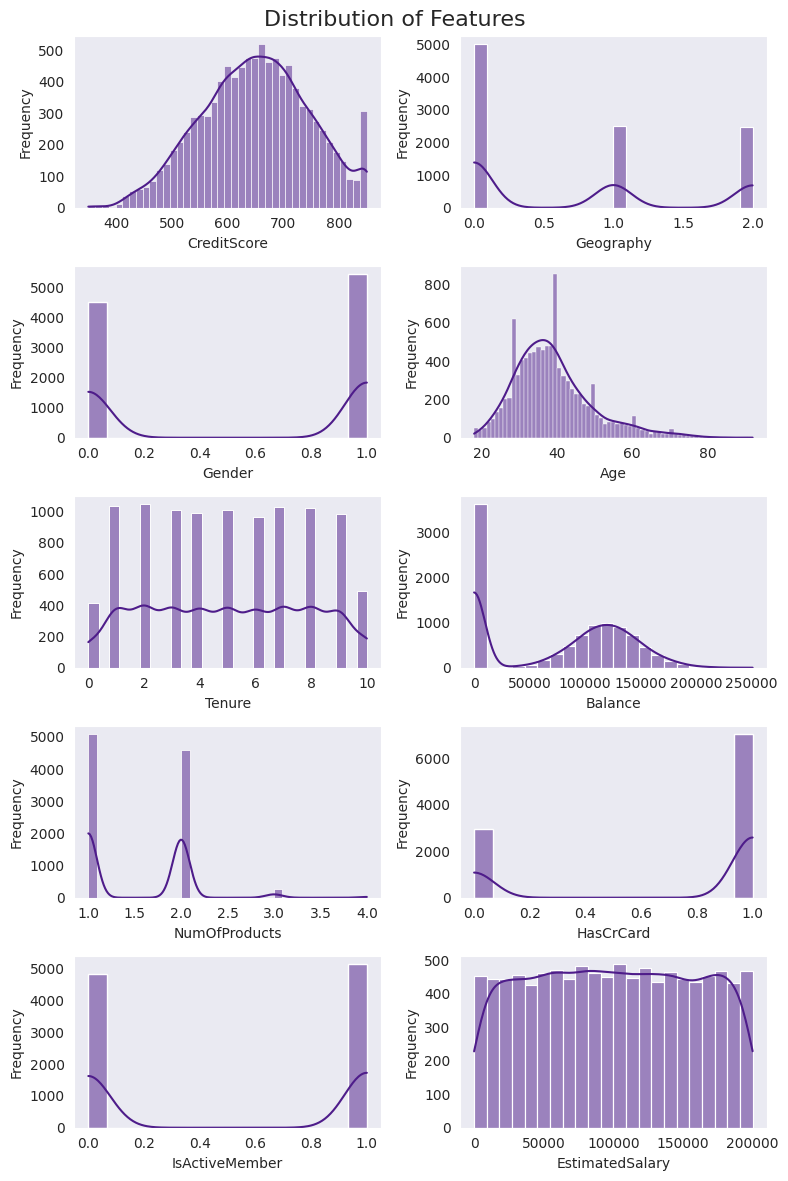

In [17]:
# Plotting distributions of each feature through histograms.

fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=5)

for i in range(len(X.columns)):
    sns.histplot(X[X.columns[i]], kde=True, ax=axes.flatten()[i], color=sequential_colors[9])
    axes.flatten()[i].set_xlabel(X.columns[i])
    axes.flatten()[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Features', fontsize=16)
plt.tight_layout()

### Comments on Distribution of Features

Three continuous features follow a relatively Gaussian distribution: CreditScore, Age and Balance. Balance shows that a substantial amount of customers have zero balance in their account. Age is slightly skewed to the right, which might potentially cause issues with neural networks. EstimatedSalary and Tenure are also continuous variables but with little resemblance to a Gaussian distribution.

Three features are binary and two of them are imbalanced: there are more men than women for Gender and more people have a credit card than not (HasCrCard). IsActiveMember is the only binary feature which is relatively balanced.

NumOfProducts is the only ordinal feature, Geography the only categorical.


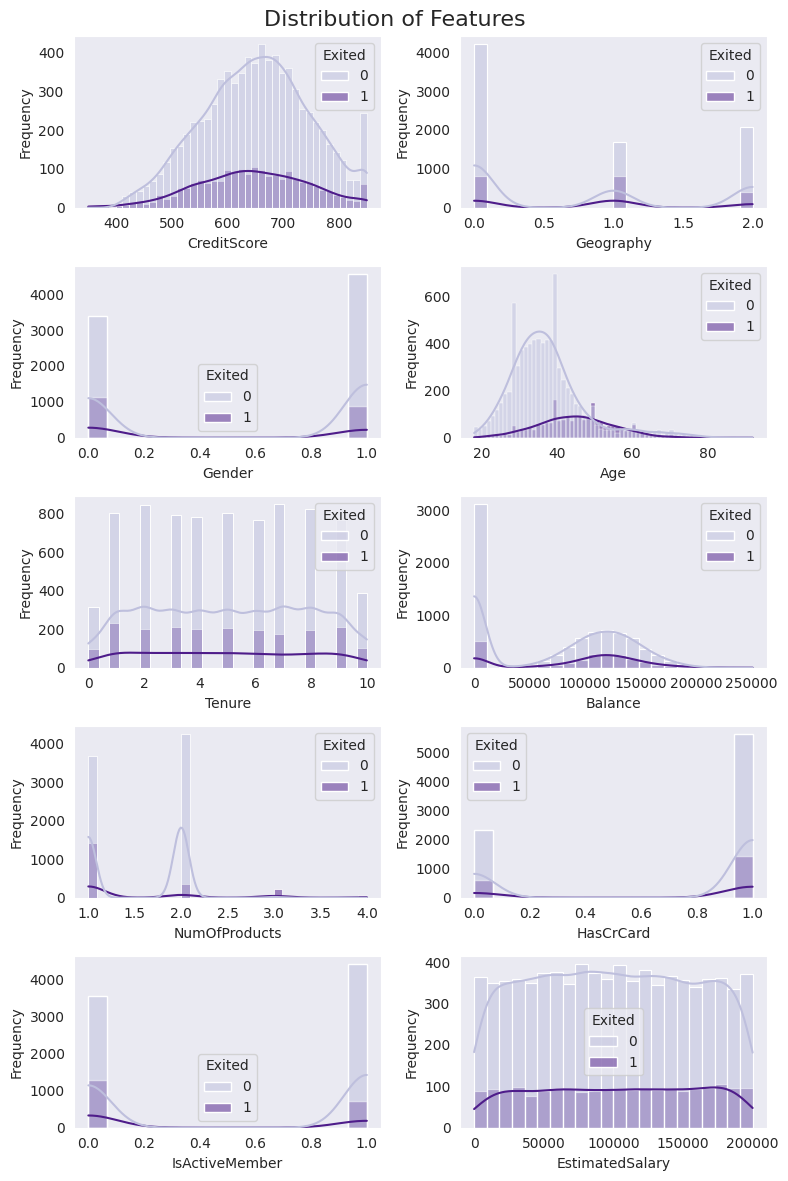

In [18]:
# Plotting relation of each features to churn through hued histograms.

fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=5)

for i in range(len(X.columns)):
    sns.histplot(data=df, x=df[df.columns[i]], kde=True, ax=axes.flatten()[i], \
                 hue='Exited', palette=[sequential_colors[3], sequential_colors[9]])
    axes.flatten()[i].set_xlabel(X.columns[i])
    axes.flatten()[i].set_ylabel('Frequency')

plt.suptitle('Distribution of Features', fontsize=16)
plt.tight_layout()

### Comments on Distribution and Churn

Five features show no discernable difference in distribution when partitioned for churn: CreditScore, Tenure, Balance, HasCrCard and EstimatedSalary.

Of the remaining five features:
- Geography: Germany seems to be much more likely to churn than France or Spain
- Gender: Women outnumber men for churning customers (opposite of total distribution).
- Age: The age distribution for churning customers shifts to the right - churning customers tend to be older on average.
- NumOfProducts: Customers with only one product seem to be more likely to churn than customers with 2 products.
- IsActiveMember: Inactive members are more likely to churn than active members.

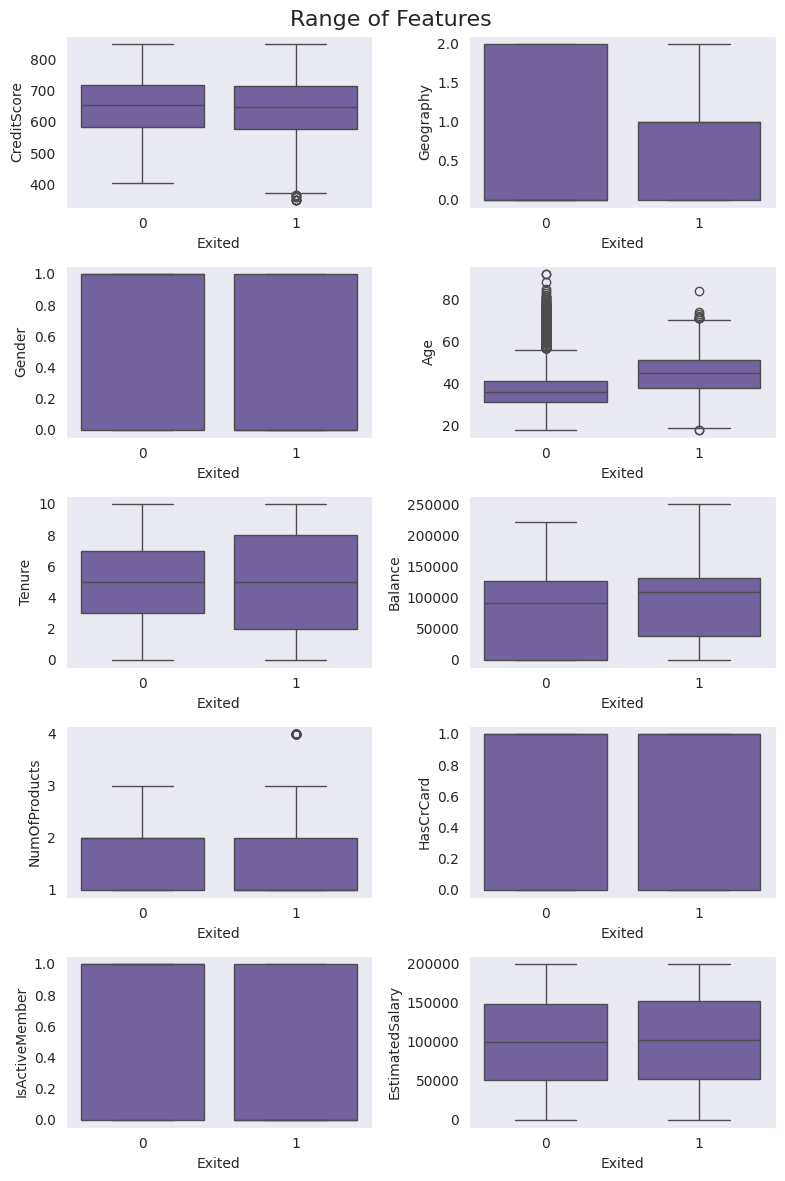

In [19]:
# Plotting ranges of each feature through boxplots.

fig, axes = plt.subplots(figsize=(8, 12), ncols=2, nrows=5)

for i in range(len(X.columns)):
    sns.boxplot(x='Exited', y=X.columns[i], data=df, ax=axes.flatten()[i], color=sequential_colors[7])

plt.suptitle('Range of Features', fontsize=16)
plt.tight_layout()

### Comments on Distributions and Ranges

There is nothing particularly useful gained from observing the ranges of the features. One fact which is reinforced however is that churning customers then to be older than those retained.

## Correlation Matrix & Bivariate Analysis

<Axes: >

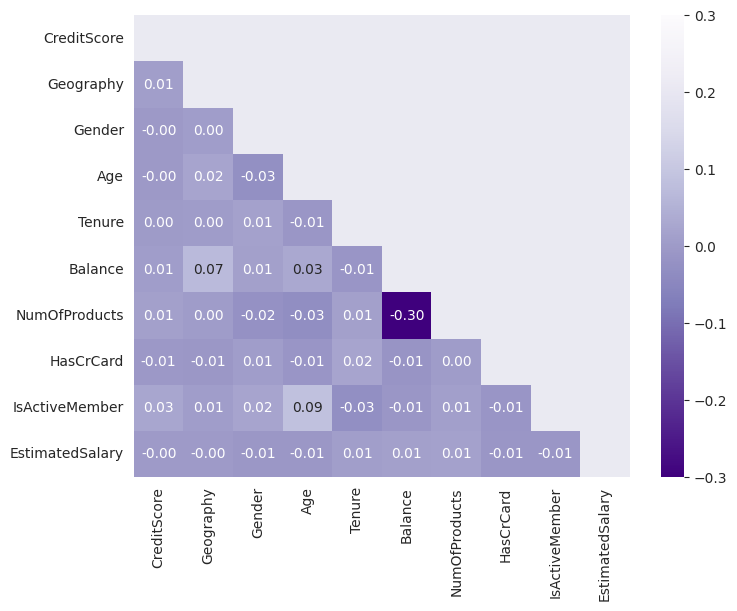

In [20]:
# Basic correlation matrix of the features.

fig = plt.figure(figsize=(8, 6))

mask = np.triu(np.ones_like(X.corr(), dtype=bool))
sns.heatmap(X.corr(), mask=mask, vmin=-0.3, vmax=0.3, annot=True, fmt='.2f', cmap='Purples_r')

Features are quite independent of one another. Only two features to have a notable covariance are NumOfProducts and Balance. This is surprising because one would normally expect the two features to have a positive relationship: customers who use multiple products have higher balances.

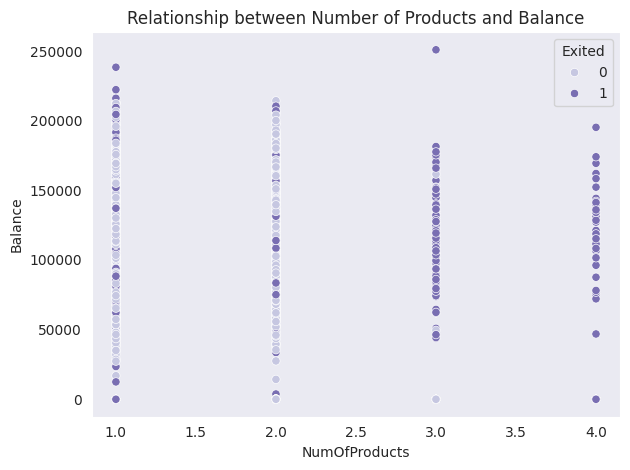

In [21]:
# Plotting relationship between NumOfProducts and Balance.

sns.scatterplot(x='NumOfProducts', y='Balance', data=df, hue='Exited', palette='Purples')

plt.title('Relationship between Number of Products and Balance')
plt.tight_layout()

### Comments on Bivariate Relationship

One can see the relationship more clearly here. As the NumOfProducts increases, the range of the Balance shrinks towards the center. It also appears that a higher NumOfProducts is far more likely to be correlated with churn. Having a high Balance doesn't seem to place a customer at risk of churn so long as they are using fewer products.

# Feature Engineering

As we have seen earlier, there exist many customers with no balance whatsoever. It might be feasible to create a new binary feature which simply asks whether a non-zero balance exists or not. This is to ensure that the odd spread of the distribution doesn't prevent the neural network from learning valuable information.

In [22]:
X['BalanceExists'] = X['Balance'].apply(lambda x: 1 if x > 0 else 0)

In [23]:
X.head()

CreditScore  Geography  Gender  Age  Tenure    Balance  \
CustomerId                                                           
15634602            619          0       0   42       2       0.00   
15647311            608          2       0   41       1   83807.86   
15619304            502          0       0   42       8  159660.80   
15701354            699          0       0   39       1       0.00   
15737888            850          2       0   43       2  125510.82   

            NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
CustomerId                                                              
15634602                1          1               1        101348.88   
15647311                1          0               1        112542.58   
15619304                3          1               0        113931.57   
15701354                2          0               0         93826.63   
15737888                1          1               1         79084.10   

            BalanceExists  
CustomerId                 
15634602                0  
15647311                1  
15619304                1  
15701354                0  
15737888                1


Likewise, credit scores are highly granular and might not make a particular difference at small scales. It might be more feasible to replace them entirely with an ordinal feature which measures whether a credit score is poor, average or good. We can use the FICO score (most common credit score measurement) which places credit scores in a range of:

- Poor: < 580
- Fair: 580-669
- Good: 670-739
- Very Good: 740-799
- Exceptional: 800+

In [24]:
def credit_score_map(score):
    if score < 580:
      return 1
    elif score < 670:
      return 2
    elif score < 740:
      return 3
    elif score < 800:
      return 4
    else:
      return 5

In [25]:
X['CreditRating'] = X['CreditScore'].apply(credit_score_map)
X.drop('CreditScore', axis=1, inplace=True)

In [26]:
X.head()

Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
CustomerId                                                             
15634602            0       0   42       2       0.00              1   
15647311            2       0   41       1   83807.86              1   
15619304            0       0   42       8  159660.80              3   
15701354            0       0   39       1       0.00              2   
15737888            2       0   43       2  125510.82              1   

            HasCrCard  IsActiveMember  EstimatedSalary  BalanceExists  \
CustomerId                                                              
15634602            1               1        101348.88              0   
15647311            0               1        112542.58              1   
15619304            1               0        113931.57              1   
15701354            0               0         93826.63              0   
15737888            1               1         79084.10              1   

            CreditRating  
CustomerId                
15634602               2  
15647311               2  
15619304               1  
15701354               3  
15737888               5

And finally, in order to identify each individual's ability to pay back their balance, let us create a new feature to measure the ratio of Balance / EstimatedSalary.

In [27]:
# Checking for potential non-zero salaries.

X[X['EstimatedSalary'] == 0].count()

Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
BalanceExists      0
CreditRating       0
dtype: int64

In [28]:
# This will measure the ease with which a customer can repay their balance.
# Lower = easier to pay back.
# Zero = Balance is zero.
# If the ratio is greater than 1, then the balance is more than the salary.

X['BalanceRatio'] = X['Balance'] / X['EstimatedSalary']

In [29]:
X.head()

Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
CustomerId                                                             
15634602            0       0   42       2       0.00              1   
15647311            2       0   41       1   83807.86              1   
15619304            0       0   42       8  159660.80              3   
15701354            0       0   39       1       0.00              2   
15737888            2       0   43       2  125510.82              1   

            HasCrCard  IsActiveMember  EstimatedSalary  BalanceExists  \
CustomerId                                                              
15634602            1               1        101348.88              0   
15647311            0               1        112542.58              1   
15619304            1               0        113931.57              1   
15701354            0               0         93826.63              0   
15737888            1               1         79084.10              1   

            CreditRating  BalanceRatio  
CustomerId                              
15634602               2      0.000000  
15647311               2      0.744677  
15619304               1      1.401375  
15701354               3      0.000000  
15737888               5      1.587055

The salary information is quite evenly spread and does not show any patterns. Granular salary information might not provide any particularly important differences. Let us replace the salary information with an ordinal value on salary level.

In [30]:
def salary_mapping(salary):
    if salary < 50000:
      return 1
    elif salary < 100000:
      return 2
    elif salary < 150000:
      return 3
    else:
      return 4

In [31]:
X['SalaryRange'] = X['EstimatedSalary'].apply(salary_mapping)
X.drop('EstimatedSalary', axis=1, inplace=True)

In [32]:
X.head()

Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
CustomerId                                                             
15634602            0       0   42       2       0.00              1   
15647311            2       0   41       1   83807.86              1   
15619304            0       0   42       8  159660.80              3   
15701354            0       0   39       1       0.00              2   
15737888            2       0   43       2  125510.82              1   

            HasCrCard  IsActiveMember  BalanceExists  CreditRating  \
CustomerId                                                           
15634602            1               1              0             2   
15647311            0               1              1             2   
15619304            1               0              1             1   
15701354            0               0              0             3   
15737888            1               1              1             5   

            BalanceRatio  SalaryRange  
CustomerId                             
15634602        0.000000            3  
15647311        0.744677            3  
15619304        1.401375            3  
15701354        0.000000            2  
15737888        1.587055            2

### Comments

In total, we have created 4 features and dropped 2.

New features:
- BalanceExists (binary)
- CreditRating (ordinal)
- BalanceRatio (continuous)
- SalaryRange (ordinal)

Dropped features:
- CreditScore (replaced by CreditRating)
- EstimatedSalary (replaced by SalaryRange)

# Supervised Modelling with Decision Trees & Random Forests

## Functions / Utilities

In [33]:
# Function to print core model metrics.
# Training accuracy, validation accuracy, ROC-AUC, Recall.

def model_metrics(model, X_train, y_train, X_val, y_val):
  print(f'Training Accuracy: {model.score(X_train, y_train):.3f}')
  print(f'Validation Accuracy: {model.score(X_val, y_val):.3f}')
  print(f'ROC-AUC: {roc_auc_score(y_val, model.predict(X_val)):.3f}')
  print(f'Recall: {recall_score(y_val, model.predict(X_val)):.3f}')
  print('\n-----\n')
  print(classification_report(y_val, model.predict(X_val)))
  print('\n-----\n')

In [34]:
# Function to measure difference in metrics between two models.
# Training accuracy, validation accuracy, ROC-AUC, Precision, Recall.

def model_metrics_with_changes(base_model, final_model, X_train, y_train, X_val, y_val):
  print('Change from Base Model')
  print('\n-----\n')
  print(f'Training Accuracy: {final_model.score(X_train, y_train) - base_model.score(X_train, y_train):.3f}')
  print(f'Validation Accuracy: {final_model.score(X_val, y_val) - base_model.score(X_val, y_val):.3f}')
  print(f'ROC AUC: {roc_auc_score(y_val, final_model.predict(X_val)) - roc_auc_score(y_val, base_model.predict(X_val)):.3f}')
  print(f'Precision: {precision_score(y_val, final_model.predict(X_val)) - precision_score(y_val, base_model.predict(X_val)):.3f}')
  print(f'Recall: {recall_score(y_val, final_model.predict(X_val)) - recall_score(y_val, base_model.predict(X_val)):.3f}')
  print('\n-----\n')
  print(confusion_matrix(y_val, final_model.predict(X_val)) - confusion_matrix(y_val, base_model.predict(X_val)))
  print('\n-----\n')

In [35]:
# Function to plot the accuracy and recall of a model across a range of feature values.

def plot_accuracy_recall(param_list, accuracy_list, recall_list, title, xlabel):

  # Finding the maximum value for validation accuracy and recall.
  max_accuracy_index = np.argmax(accuracy_list)
  max_recall_index = np.argmax(recall_list)

  # Plotting the figure.
  plt.plot(param_list, accuracy_list)
  plt.plot(param_list, recall_list)
  plt.legend(['Accuracy', 'Recall'])
  plt.xlabel(xlabel)
  plt.ylabel('Score')
  plt.xlim(min(param_list), max(param_list))
  plt.ylim(0.25, 1)
  plt.vlines(param_list[max_accuracy_index], 0.25, 1, color='steelblue', linestyles='dashed')
  plt.vlines(param_list[max_recall_index], 0.25, 1, color='orange', linestyles='dashed')
  plt.title(title)
  plt.show()

In [36]:
# Creating a dictionary with keys 0-9 and header values as values.

header_dict = {}
for i in range(len(X.columns)):
    if i < len(X.columns):
        header_dict[i] = X.columns[i]
    else:
        header_dict[i] = None

header_dict

{0: 'Geography',
 1: 'Gender',
 2: 'Age',
 3: 'Tenure',
 4: 'Balance',
 5: 'NumOfProducts',
 6: 'HasCrCard',
 7: 'IsActiveMember',
 8: 'BalanceExists',
 9: 'CreditRating',
 10: 'BalanceRatio',
 11: 'SalaryRange'}

In [37]:
# Function to plot feature importances.

def plot_feature_importances(model, header_dict, title):

  # Obtaining feature importances and sorting them.
  feature_importances = model.feature_importances_
  sorted_indices = np.argsort(feature_importances)[::-1]
  sorted_importances = feature_importances[sorted_indices]

  # Preparing x-axis labels using header_dict.
  x_labels = [header_dict.get(i) for i in sorted_indices if header_dict.get(i) is not None]

  # Plotting the figure.
  plt.figure(figsize=(10, 6))
  plt.bar(range(len(sorted_importances)), sorted_importances)
  plt.xticks(range(len(sorted_importances)), x_labels, rotation=45, ha='right')
  plt.xlabel("Features")
  plt.ylabel("Importance")
  plt.title(f"Feature Importances from {str(title)}")
  plt.tight_layout()

In [38]:
# Function to plot a confusion matrix.
# Intended to measure false positives, false negatives, F1-score, etc.

def plot_confusion_matrix(y_true, y_pred, title):

  # Generating the confusion matrix.
  cm = confusion_matrix(y_val, y_pred)

  # Plotting the figure.
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['Actual 0', 'Actual 1'])
  plt.title(f'Confusion Matrix for {title}')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

## Preprocessing

In [39]:
# Scaling the values to a range of [0, 1] such that gradient optimization can be smoother for neural networks.

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

In [40]:
X[:5]

Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
CustomerId                                                             
15634602            0       0   42       2       0.00              1   
15647311            2       0   41       1   83807.86              1   
15619304            0       0   42       8  159660.80              3   
15701354            0       0   39       1       0.00              2   
15737888            2       0   43       2  125510.82              1   

            HasCrCard  IsActiveMember  BalanceExists  CreditRating  \
CustomerId                                                           
15634602            1               1              0             2   
15647311            0               1              1             2   
15619304            1               0              1             1   
15701354            0               0              0             3   
15737888            1               1              1             5   

            BalanceRatio  SalaryRange  
CustomerId                             
15634602        0.000000            3  
15647311        0.744677            3  
15619304        1.401375            3  
15701354        0.000000            2  
15737888        1.587055            2

In [41]:
X_scaled[:5].round(3)

array([[0.   , 0.   , 0.324, 0.2  , 0.   , 0.   , 1.   , 1.   , 0.   ,
        0.25 , 0.   , 0.667],
       [1.   , 0.   , 0.311, 0.1  , 0.334, 0.   , 0.   , 1.   , 1.   ,
        0.25 , 0.   , 0.667],
       [0.   , 0.   , 0.324, 0.8  , 0.636, 0.667, 1.   , 0.   , 1.   ,
        0.   , 0.   , 0.667],
       [0.   , 0.   , 0.284, 0.1  , 0.   , 0.333, 0.   , 0.   , 0.   ,
        0.5  , 0.   , 0.333],
       [1.   , 0.   , 0.338, 0.2  , 0.5  , 0.   , 1.   , 1.   , 1.   ,
        1.   , 0.   , 0.333]])

In [42]:
# Splitting the data off into train/val/test splits of 80/10/10.

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.10, stratify=y, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, stratify=y_train, random_state=123)

In [43]:
# Checking shapes.

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 12)
(8000,)
(1000, 12)
(1000,)
(1000, 12)
(1000,)


In [44]:
# Checking stratification to ensure that we have similar proportions of churn in each set.

print(y_train.value_counts() / len(y_train))
print(y_val.value_counts() / len(y_val))
print(y_test.value_counts() / len(y_test))

Exited
0    0.796375
1    0.203625
Name: count, dtype: float64
Exited
0    0.796
1    0.204
Name: count, dtype: float64
Exited
0    0.796
1    0.204
Name: count, dtype: float64


## Decision Tree Classifier

Decision Trees are a standard classification method which can be used as a base model going forward. The model ought to fit this data quite well as it is a straightforward binary classification problem with only ten features.

Let's explore the Decision Tree Classifier along with the tuning of its hyperparameters.

### Base Decision Tree Model

In [106]:
# Building a base model.

base_tree = DecisionTreeClassifier(random_state=123)
base_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

In [107]:
# Predicting values and observing scoring metrics.

base_tree_pred = base_tree.predict(X_val)

model_metrics(base_tree, X_train, y_train, X_val, y_val)

print(f'Depth: {base_tree.get_depth()}')
print(f'Number of Leaves: {base_tree.get_n_leaves()}')
print(f'Number of Features: {base_tree.n_features_in_}')

Training Accuracy: 0.999
Validation Accuracy: 0.792
ROC-AUC: 0.696
Recall: 0.534

-----

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       796
           1       0.49      0.53      0.51       204

    accuracy                           0.79      1000
   macro avg       0.68      0.70      0.69      1000
weighted avg       0.80      0.79      0.80      1000


-----

Depth: 25
Number of Leaves: 1304
Number of Features: 12


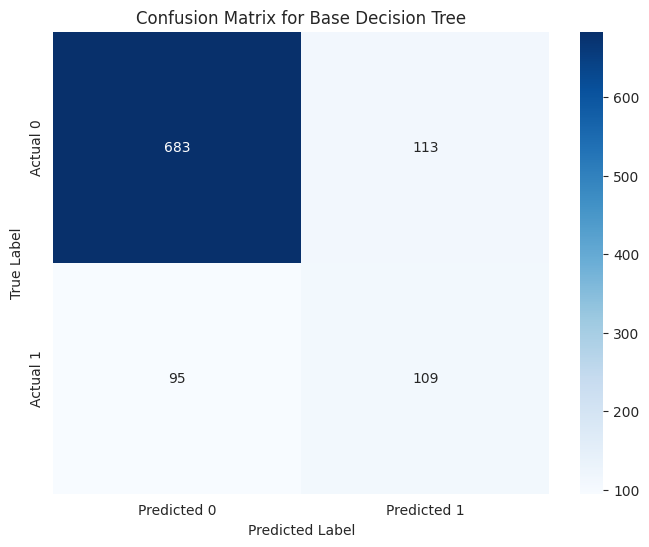

In [108]:
# Plotting a confusion matrix.

plot_confusion_matrix(y_val, base_tree_pred, 'Base Decision Tree')

In [109]:
# Retrieving parameters of base model.

base_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 123,
 'splitter': 'best'}

In [110]:
# Retrieving feature importances of base model.

base_tree.feature_importances_

array([0.04478689, 0.02270993, 0.25803932, 0.10036471, 0.15383998,
       0.11805879, 0.02593629, 0.0514392 , 0.00286183, 0.05745526,
       0.13294702, 0.03156077])

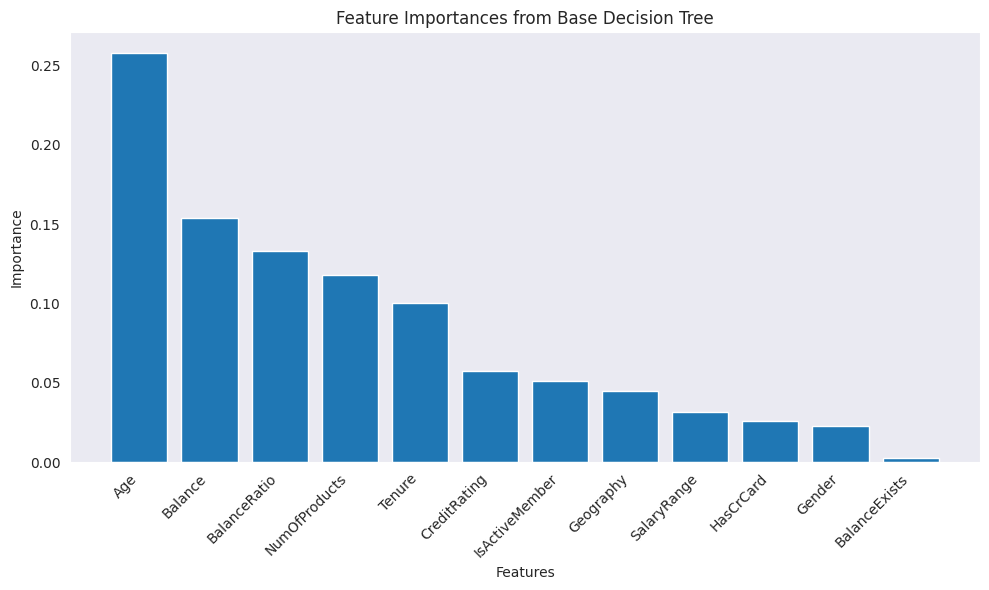

In [120]:
# Plotting feature importances.

plot_feature_importances(base_tree, header_dict, 'Base Decision Tree')

### Comments

We can see that the base Decision Tree model provides some importance to all the features, although many are nearly zero. The base validation accuracy of 0.792 is not bad either but the tree has absolutely overfit with a training accuracy of 0.999.

The F1-Score is 0.51. Both the precision and recall scores for churning customers are quite poor. The base model is unable to accurately distinguish the churned customers and is likely to miss them altogether as false negatives (recall = 0.53). The value for precision of churned customers is also a paltry 0.49.

It might be wiser to aim for a high recall rather than a high precision. Since we are trying to minimize churn, it will likely be done through reaching out and offering better deals to at-risk customers. It is best to cast a large net and focus on reducing false negatives (i.e. higher recall) than worry about false positives. Customers who are *not* at-risk of churn certainly won't mind receiving an extra call or email for a new product offering. But those who are already considering leaving the bank will not be stopped unless convinced that remaining with this current bank is in their best interests.

We will see below if hyperparameter tuning is able to relieve some of these issues. Hyperparameters will be charted with jagged lines identifying the maximum point of validation score and recall. These graphs will then be used to identify a range of values which will be sifted through with a Randomized Search and a Bayesian Search.

### Hyperparameter Tuning

In [121]:
# Observing metrics by criterion.

criterion_list = ['gini', 'entropy']

for criterion in criterion_list:
    tree = DecisionTreeClassifier(criterion=criterion, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    print(f'Criterion: {criterion}')
    print('-----')
    print(f'Accuracy: {accuracy_score(y_val, tree_pred):.3f}')
    print(f'Recall: {recall_score(y_val, tree_pred):.3f}')
    print('-----')
    print(classification_report(y_val, tree_pred))
    print('-----')
    print(confusion_matrix(y_val, tree_pred))
    print('-----')

Criterion: gini
-----
Accuracy: 0.792
Recall: 0.534
-----
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       796
           1       0.49      0.53      0.51       204

    accuracy                           0.79      1000
   macro avg       0.68      0.70      0.69      1000
weighted avg       0.80      0.79      0.80      1000

-----
[[683 113]
 [ 95 109]]
-----
Criterion: entropy
-----
Accuracy: 0.784
Recall: 0.500
-----
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       796
           1       0.47      0.50      0.49       204

    accuracy                           0.78      1000
   macro avg       0.67      0.68      0.67      1000
weighted avg       0.79      0.78      0.79      1000

-----
[[682 114]
 [102 102]]
-----


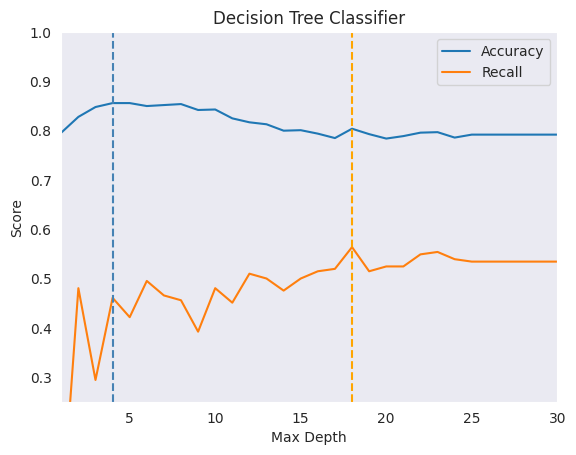

In [122]:
# Observing metrics by max_depth.

max_depth_list = np.arange(1, 31)
accuracy_list = []
recall_list = []

for max_depth in max_depth_list:
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))

plot_accuracy_recall(max_depth_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Max Depth')

In [123]:
# Observing metrics by max_features.

max_features_list = ['sqrt', 'log2', None]
accuracy_list = []
recall_list = []

for max_features in max_features_list:
    tree = DecisionTreeClassifier(max_features=max_features, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))
    print(f'Max Features: {max_features}')
    print(f'Number of Features: {tree.max_features_}')
    print('-----')
    print(f'Accuracy: {accuracy_score(y_val, tree_pred):.3f}')
    print(f'ROC AUC: {recall_score(y_val, tree_pred):.3f}')
    print('-----')
    print(classification_report(y_val, tree_pred))
    print('-----')
    print(confusion_matrix(y_val, tree_pred))
    print('-----')

Max Features: sqrt
Number of Features: 3
-----
Accuracy: 0.799
ROC AUC: 0.529
-----
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       796
           1       0.51      0.53      0.52       204

    accuracy                           0.80      1000
   macro avg       0.69      0.70      0.70      1000
weighted avg       0.80      0.80      0.80      1000

-----
[[691 105]
 [ 96 108]]
-----
Max Features: log2
Number of Features: 3
-----
Accuracy: 0.799
ROC AUC: 0.529
-----
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       796
           1       0.51      0.53      0.52       204

    accuracy                           0.80      1000
   macro avg       0.69      0.70      0.70      1000
weighted avg       0.80      0.80      0.80      1000

-----
[[691 105]
 [ 96 108]]
-----
Max Features: None
Number of Features: 12
-----
Accuracy: 0.792
ROC AUC: 0.534
-----
              precision

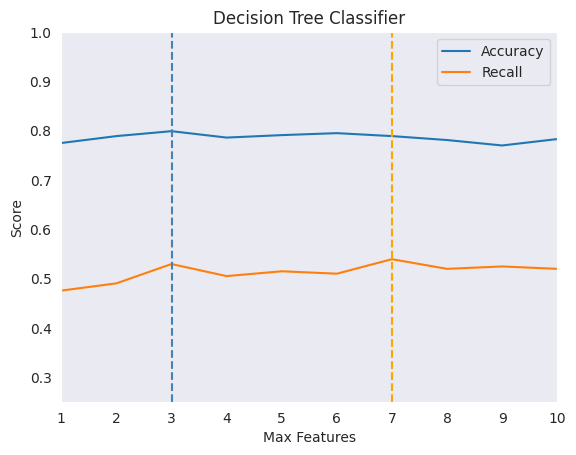

In [124]:
# Observing metrics by max_features.

max_features_list = np.arange(1, 11)
accuracy_list = []
recall_list = []

for max_features in max_features_list:
    tree = DecisionTreeClassifier(max_features=max_features, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))

plot_accuracy_recall(max_features_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Max Features')

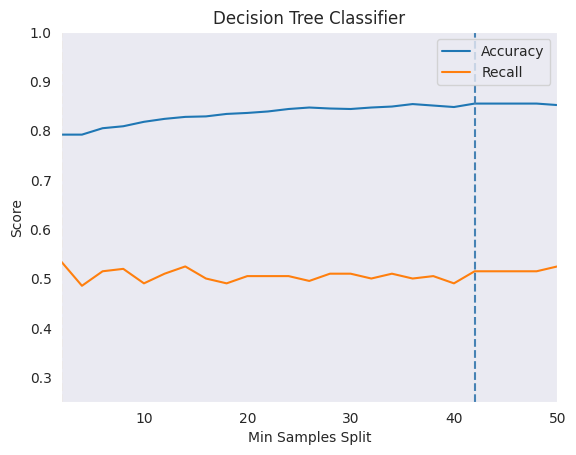

In [125]:
# Observing metrics by min_samples_split.

min_samples_split_list = np.arange(2, 51, 2)
accuracy_list = []
recall_list = []

for min_samples_split in min_samples_split_list:
    tree = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))

plot_accuracy_recall(min_samples_split_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Min Samples Split')

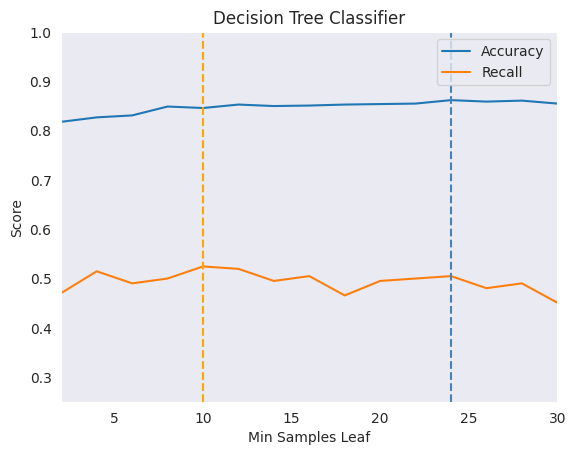

In [126]:
# Observing metrics by min_samples_leaf.

min_samples_leaf_list = np.arange(2, 31, 2)
accuracy_list = []
recall_list = []

for min_samples_leaf in min_samples_leaf_list:
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))

plot_accuracy_recall(min_samples_leaf_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Min Samples Leaf')

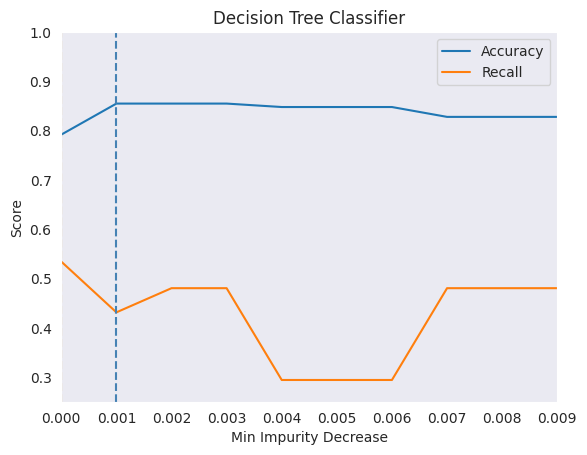

In [127]:
# Observing metrics by min_impurity_decrease.

min_impurity_decrease_list = np.arange(0, 0.01, 0.001)
accuracy_list = []
recall_list = []

for min_impurity_decrease in min_impurity_decrease_list:
    tree = DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease, random_state=123)
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_val)
    accuracy = accuracy_score(y_val, tree_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, tree_pred))


plot_accuracy_recall(min_impurity_decrease_list, accuracy_list, recall_list, \
                      'Decision Tree Classifier', 'Min Impurity Decrease')

### Randomized & Bayesian Search

Here we will experiment with a Randomized Search and a Bayesian Search. Both methods will be used in order to explore improvements in efficiency of hyperparameter tuning. We'll choose the range of values based on the previous graphs, which highlight for us the values where validation accuracies and ROC-AUC scores are the highest.

In [166]:
# Since neither the validation score nor the recall particularly changed across the hyperparameters,
# we will be casting a broad net with the RandomizedSearch parameter grid.

from sklearn.model_selection import RandomizedSearchCV

criterion_list = ['gini', 'entropy']
max_depth_list = np.arange(5, 26)
max_features_list = np.arange(1, 13)
min_samples_leaf_list = np.arange(5, 31)
min_samples_split_list = np.arange(5, 51)

tree_param_grid = {'criterion': criterion_list,
              'max_depth': max_depth_list,
              'max_features': max_features_list,
              'min_samples_leaf': min_samples_leaf_list,
              'min_samples_split': min_samples_split_list}

In [167]:
# Finding the optimal model with randomized search.

%%time

randomized_tree = DecisionTreeClassifier(random_state=123)
random_search = RandomizedSearchCV(randomized_tree, tree_param_grid, scoring='recall', \
                                   n_iter = 500, cv = 5, random_state=123)
random_search.fit(X_train, y_train)

CPU times: user 40.7 s, sys: 65.4 ms, total: 40.8 s
Wall time: 42.1 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
                   n_iter=500,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25]),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
                                        'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
                   random_state=123, scoring='recall')

In [169]:
# Printing score and parameter values for the optimal model.

print(random_search.best_score_)
print(accuracy_score(y_val, random_search.predict(X_val)))
print(random_search.best_params_)

0.5089211892402077
0.842
{'min_samples_split': np.int64(19), 'min_samples_leaf': np.int64(7), 'max_features': np.int64(8), 'max_depth': np.int64(20), 'criterion': 'gini'}


In [170]:
# Narrowing the Bayesian search range to minimize the time required to find the optimal solution.

bayes_criterion_list = ['gini', 'entropy']
bayes_max_depth_list = np.arange(10, 31)
bayes_max_features_list = np.arange(6, 13)
bayes_min_samples_leaf_list = np.arange(5, 16)
bayes_min_samples_split_list = np.arange(15, 31)

bayes_tree_param_grid = {'criterion': bayes_criterion_list,
              'max_depth': bayes_max_depth_list,
              'max_features': bayes_max_features_list,
              'min_samples_leaf': bayes_min_samples_leaf_list,
              'min_samples_split': bayes_min_samples_split_list}

In [196]:
# Finding the optimal model with Bayesian Search.

%%time

from skopt import BayesSearchCV

opt = BayesSearchCV(DecisionTreeClassifier(random_state=123), bayes_tree_param_grid, scoring='recall', \
                    n_iter=100, cv=5, random_state=123)
opt.fit(X_train, y_train)

CPU times: user 29min 14s, sys: 1min 35s, total: 30min 49s
Wall time: 19min 52s


BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=123),
              n_iter=100, random_state=123, scoring='recall',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30]),
                             'max_features': array([ 6,  7,  8,  9, 10, 11, 12]),
                             'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                             'min_samples_split': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])})

In [197]:
# Printing the score and parameter values of the optimal model.

print(opt.best_score_)
print(accuracy_score(y_val, opt.predict(X_val)))
print(opt.best_params_)

0.5051986786219915
0.832
OrderedDict([('criterion', 'entropy'), ('max_depth', 20), ('max_features', 9), ('min_samples_leaf', 5), ('min_samples_split', 22)])


Bayesian Search returns a marginally better score for the Decision Tree Classifier.

### Final Decision Tree Model

In [48]:
# Creating the final tree model.

final_tree = DecisionTreeClassifier(min_samples_split = 22, min_samples_leaf = 5, max_features = 9, \
                                    max_depth = 20, criterion = 'entropy', random_state=123)
final_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=9,
                       min_samples_leaf=5, min_samples_split=22,
                       random_state=123)

In [49]:
# Observing metrics for the final model.

final_tree_pred = final_tree.predict(X_val)

model_metrics(final_tree, X_train, y_train, X_val, y_val)

print(f'Depth: {final_tree.get_depth()}')
print(f'Number of Leaves: {final_tree.get_n_leaves()}')
print(f'Number of Features: {final_tree.n_features_in_}')

Training Accuracy: 0.894
Validation Accuracy: 0.832
ROC-AUC: 0.725
Recall: 0.544

-----

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       796
           1       0.60      0.54      0.57       204

    accuracy                           0.83      1000
   macro avg       0.74      0.72      0.73      1000
weighted avg       0.83      0.83      0.83      1000


-----

Depth: 20
Number of Leaves: 448
Number of Features: 12


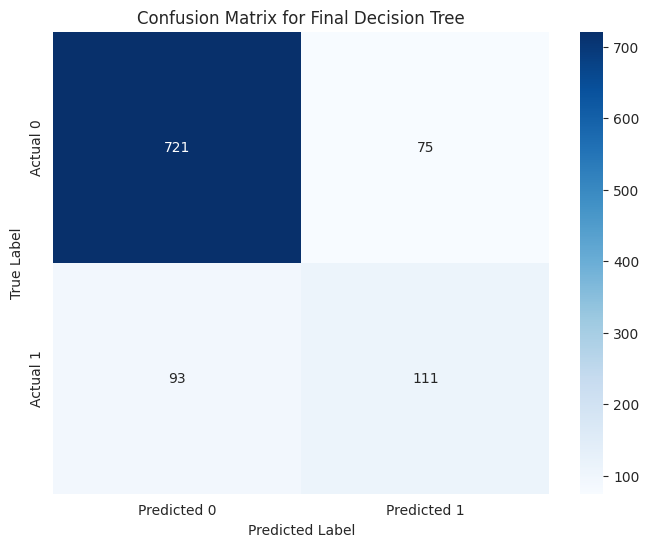

In [200]:
# Plotting confusion matrix.

plot_confusion_matrix(y_val, final_tree_pred, 'Final Decision Tree')

In [201]:
# Observing feature importances.
final_tree.feature_importances_

array([0.05396585, 0.02264239, 0.31284531, 0.06437068, 0.12714831,
       0.19936953, 0.0062276 , 0.06510796, 0.00276303, 0.02610007,
       0.09390479, 0.02555448])

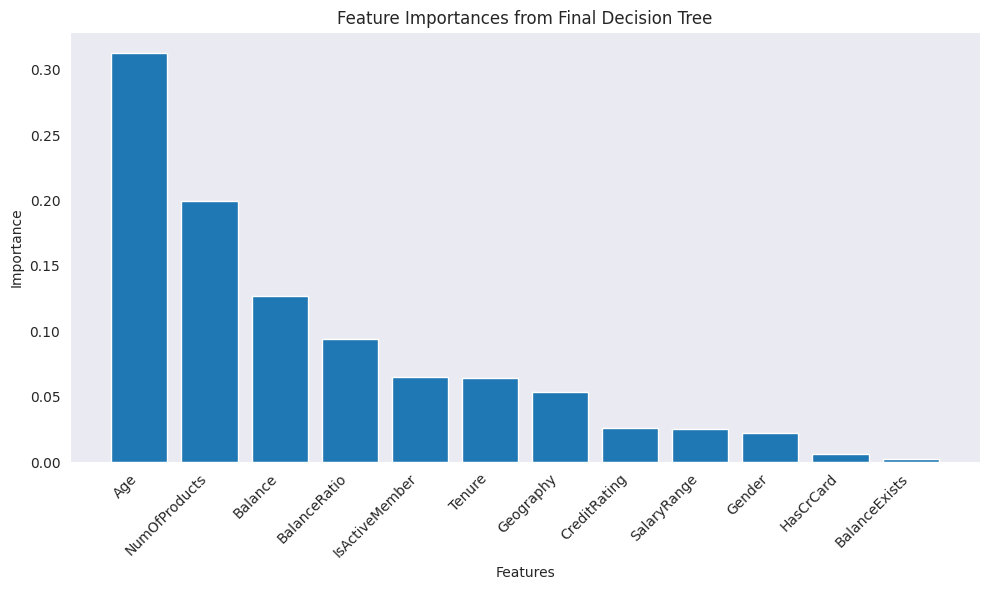

In [202]:
# Plotting feature importances.

plot_feature_importances(final_tree, header_dict, 'Final Decision Tree')

In [203]:
# Observing changes in metrics.

model_metrics_with_changes(base_tree, final_tree, X_train, y_train, X_val, y_val)

print(f'Depth: {final_tree.get_depth() - base_tree.get_depth()}')
print(f'Number of Leaves: {final_tree.get_n_leaves() - base_tree.get_n_leaves()}')
print(f'Number of Features: {final_tree.n_features_in_ - base_tree.n_features_in_}')
print('\n-----\n')
print(f'Feature Importances: {final_tree.feature_importances_ - base_tree.feature_importances_}')

Change from Base Model

-----

Training Accuracy: -0.106
Validation Accuracy: 0.040
ROC AUC: 0.029
Precision: 0.106
Recall: 0.010

-----

[[ 38 -38]
 [ -2   2]]

-----

Depth: -5
Number of Leaves: -856
Number of Features: 0

-----

Feature Importances: [ 9.17895658e-03 -6.75382834e-05  5.48059958e-02 -3.59940262e-02
 -2.66916663e-02  8.13107345e-02 -1.97086946e-02  1.36687668e-02
 -9.88007147e-05 -3.13551972e-02 -3.90422364e-02 -6.00629394e-03]


Hyperparameter tuning has yielded a substantial decrease in overfitting. Generalization was improved by a value of 0.040 with a reduction in training score by 0.106.

Feature importances have been significantly shifted. The base model placed an emphasis on 5 features (feature importance range of 0.10-0.30). The final model focuses on three features: Age, NumOfProducts and Balance. This may open up the potentiality for dimensionality reduction for neural networks, but that will not be explored at this present moment.

As mentioned earlier, older customers and those with more products are more likely to leave. Those with a high Balance or Balance Ratio are also likely to leave. The decision tree model manages to sustain a recall of 0.544 in its final edition. The recall score is still quite low but it marks an improvement from the base model (0.534). It is also possible that this data set is not detailed enough to sustain a high recall. Perhaps some of this can be mitigated by artificially generating new samples of the underrepresented class (churning customers), but one would hope that having a stratification of 20% would be sufficient for a model to discern churning from non-churning customers.

Nevertheless, the final decision tree model does manage to sustain a validation score of 0.832 with a substantial reduction in the training score, so there has been some progress made.


## Random Forest Classifier

The second classification method to be explored will be Random Forests. Random Forests follow a similar method to Decision Trees with two key distinctions: it uses the bootstrap method to choose a random set of samples to build trees and it uses a random subset of max_features to build each tree. These two settings of randomness ought to ensure that Random Forests be less prone to overfitting than Decision Trees. The idea is that the various causes of variance will cancel each other out and the final model will yield an averaged error rate.

Let's see how the Random Forest performs on the data along with the tuning of its hyperparameters.

### Base Random Forest Model

In [204]:
# Building a base model.

base_forest = RandomForestClassifier(random_state=123)
base_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [205]:
# Observing metrics for base model.

base_forest_pred = base_forest.predict(X_val)

model_metrics(base_forest, X_train, y_train, X_val, y_val)

print(f'Number of Estimators: {base_forest.n_estimators}')

Training Accuracy: 0.999
Validation Accuracy: 0.856
ROC-AUC: 0.713
Recall: 0.471

-----

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       796
           1       0.73      0.47      0.57       204

    accuracy                           0.86      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.85      0.86      0.84      1000


-----

Number of Estimators: 100


In [206]:
# Observing parameters.

base_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

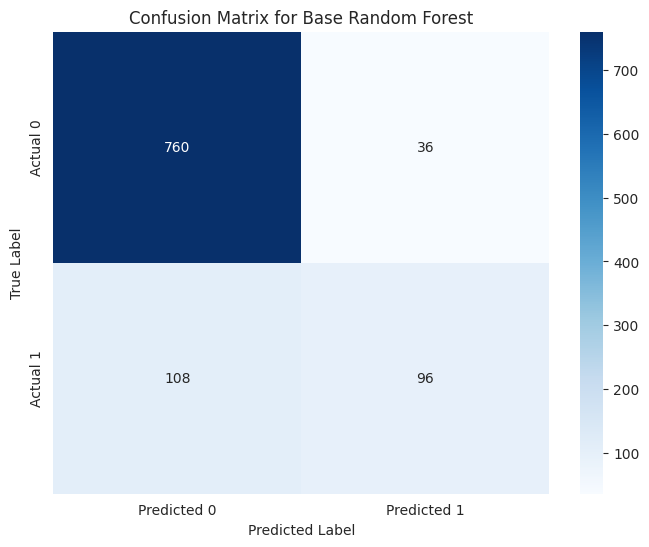

In [207]:
# Plotting the confusion matrix.

plot_confusion_matrix(y_val, base_forest_pred, 'Base Random Forest')

In [208]:
# Observing feature importances.

base_forest.feature_importances_

array([0.04243779, 0.02269849, 0.26795184, 0.10240709, 0.12992591,
       0.13468678, 0.02296313, 0.03990737, 0.00681032, 0.06179729,
       0.11845764, 0.04995635])

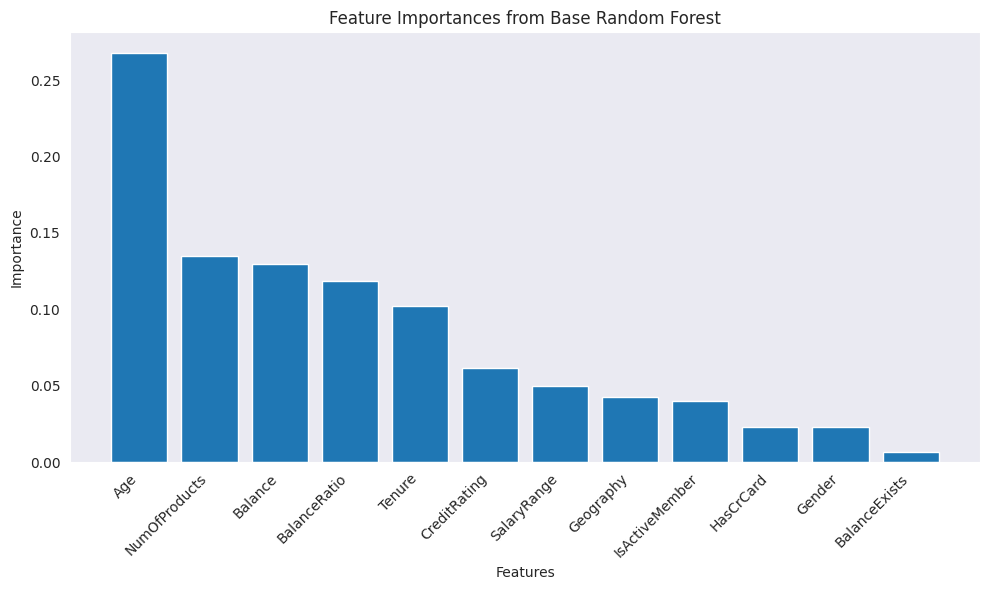

In [209]:
# Plotting feature importances.

plot_feature_importances(base_forest, header_dict, 'Base Random Forest')

### Comments

The base model overfits absolutely but the validation accuracy is much higher than the base Decision Tree model. Recall score is unfortunately lower.

### Hyperparameter Tuning

In [210]:
# Observing metrics by criterion.

criterion_list = ['gini', 'entropy']

for criterion in criterion_list:
    forest = RandomForestClassifier(criterion=criterion, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    print(f'Criterion: {criterion}')
    print('-----')
    print(f'Accuracy: {accuracy_score(y_val, forest_pred):.3f}')
    print(f'Recall: {recall_score(y_val, forest_pred):.3f}')
    print('-----')
    print(classification_report(y_val, forest_pred))
    print('-----')
    print(confusion_matrix(y_val, forest_pred))
    print('-----')

Criterion: gini
-----
Accuracy: 0.856
Recall: 0.471
-----
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       796
           1       0.73      0.47      0.57       204

    accuracy                           0.86      1000
   macro avg       0.80      0.71      0.74      1000
weighted avg       0.85      0.86      0.84      1000

-----
[[760  36]
 [108  96]]
-----
Criterion: entropy
-----
Accuracy: 0.859
Recall: 0.471
-----
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       796
           1       0.74      0.47      0.58       204

    accuracy                           0.86      1000
   macro avg       0.81      0.71      0.75      1000
weighted avg       0.85      0.86      0.85      1000

-----
[[763  33]
 [108  96]]
-----


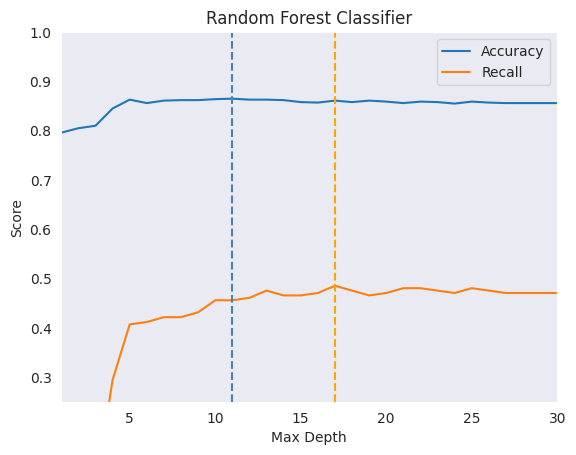

In [211]:
# Observing metrics by max_depth.

max_depth_list = np.arange(1, 31)
accuracy_list = []
recall_list = []

for max_depth in max_depth_list:
    forest = RandomForestClassifier(max_depth=max_depth, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(max_depth_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Max Depth')

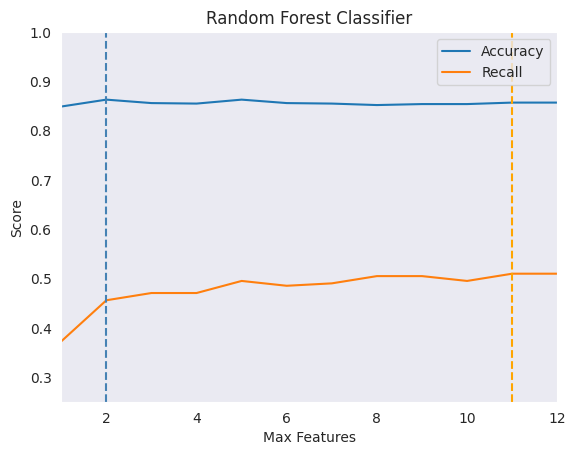

In [212]:
# Observing metrics by max_features.

max_features_list = np.arange(1, 13)
accuracy_list = []
recall_list = []

for max_features in max_features_list:
    forest = RandomForestClassifier(max_features=max_features, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(max_features_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Max Features')

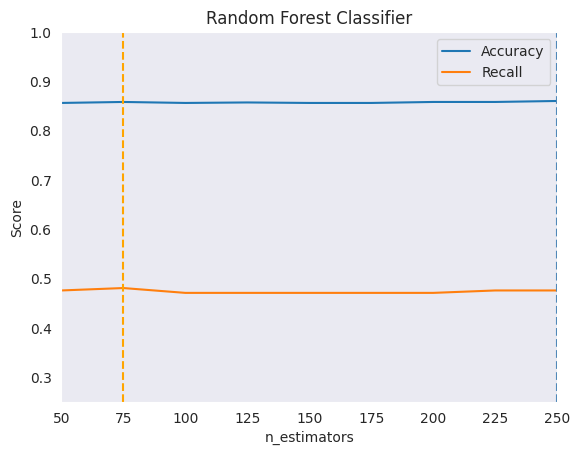

In [213]:
# Observing metrics by n_estimators.

n_estimators_list = np.arange(50, 251, 25)
accuracy_list = []
recall_list = []

for n_estimators in n_estimators_list:
    forest = RandomForestClassifier(n_estimators=n_estimators, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(n_estimators_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'n_estimators')

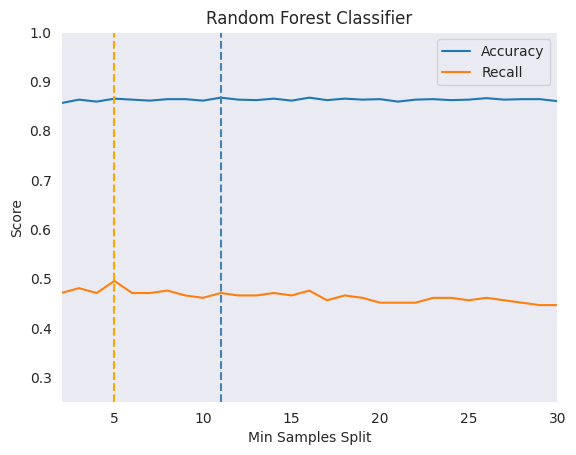

In [214]:
# Observing metrics by min_samples_split.

min_samples_split_list = np.arange(2, 31)
accuracy_list = []
recall_list = []

for min_samples_split in min_samples_split_list:
    forest = RandomForestClassifier(min_samples_split=min_samples_split, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(min_samples_split_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Min Samples Split')

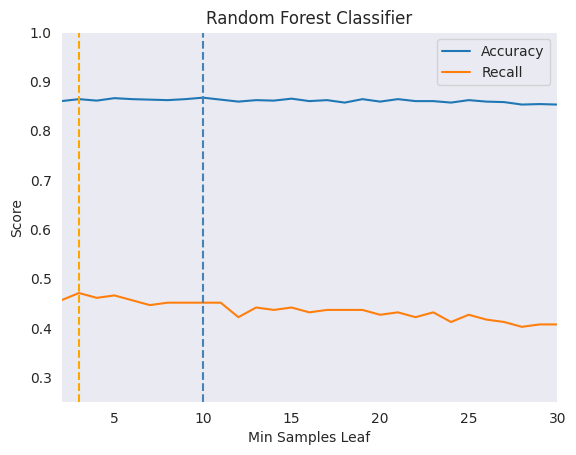

In [215]:
# Observing metrics by min_samples_leaf.

min_samples_leaf_list = np.arange(2, 31)
accuracy_list = []
recall_list = []

for min_samples_leaf in min_samples_leaf_list:
    forest = RandomForestClassifier(min_samples_leaf=min_samples_leaf, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(min_samples_leaf_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Min Samples Leaf')

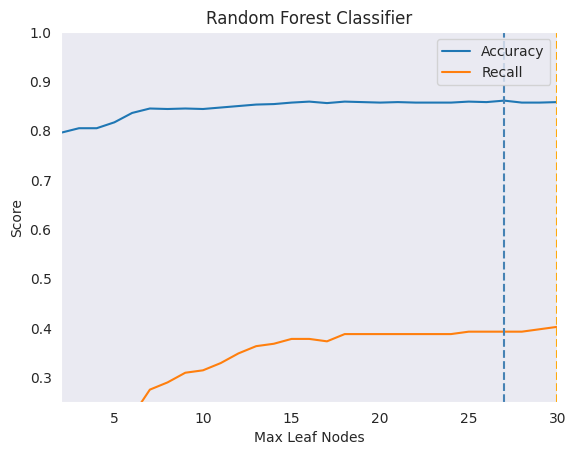

In [216]:
# Observing metrics by max_leaf_nodes.

max_leaf_nodes_list = np.arange(2, 31)
accuracy_list = []
recall_list = []

for max_leaf_nodes in max_leaf_nodes_list:
    forest = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, random_state=123)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)
    accuracy = accuracy_score(y_val, forest_pred)
    accuracy_list.append(accuracy)
    recall_list.append(recall_score(y_val, forest_pred))

plot_accuracy_recall(max_leaf_nodes_list, accuracy_list, recall_list, \
                      'Random Forest Classifier', 'Max Leaf Nodes')

### Randomized & Bayesian Search

In [225]:
# Establishing a parameter grid.

from sklearn.model_selection import RandomizedSearchCV

criterion_list = ['gini', 'entropy']
max_depth_list = np.arange(10, 26)
max_features_list = np.arange(5, 13)
n_estimators_list = np.arange(50, 251, 25)
min_samples_split_list = np.arange(2, 31)
min_samples_leaf_list = np.arange(2, 31)
max_leaf_nodes_list = np.arange(2, 31)

random_forest_param_grid = {'criterion': criterion_list,
              'max_depth': max_depth_list,
              'max_features': max_features_list,
              'n_estimators': n_estimators_list,
              'min_samples_split': min_samples_split_list,
              'min_samples_leaf': min_samples_leaf_list,
              'max_leaf_nodes': max_leaf_nodes_list}

In [226]:
# Optimizing model with RandomizedSearch.

%%time

random_search_random_forest = RandomizedSearchCV(RandomForestClassifier(random_state=123), random_forest_param_grid, scoring='recall', \
                                   n_iter = 250, cv = 5, random_state=123)
random_search_random_forest.fit(X_train, y_train)

CPU times: user 24min 32s, sys: 2.69 s, total: 24min 35s
Wall time: 24min 39s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
                   n_iter=250,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
                                        'max_features': array([ 5,  6,  7,  8,  9, 10, 11, 12]),
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'min_samples_leaf': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                        'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250])},
                   random_state=123, scoring='recall')

In [227]:
# Printing score and parameters for optimal model.

print(random_search_random_forest.best_score_)
print(accuracy_score(y_val, random_search_random_forest.predict(X_val)))
print(random_search_random_forest.best_params_)

0.44507031618688064
0.863
{'n_estimators': np.int64(125), 'min_samples_split': np.int64(26), 'min_samples_leaf': np.int64(18), 'max_leaf_nodes': np.int64(29), 'max_features': np.int64(11), 'max_depth': np.int64(23), 'criterion': 'gini'}


In [231]:
# Establishing a parameter grid.

from sklearn.model_selection import RandomizedSearchCV

bayes_criterion_list = ['gini', 'entropy']
bayes_max_depth_list = np.arange(15, 31)
bayes_max_features_list = np.arange(7, 13)
bayes_n_estimators_list = np.arange(75, 151, 25)
bayes_min_samples_split_list = np.arange(20, 31)
bayes_min_samples_leaf_list = np.arange(15, 26)
bayes_max_leaf_nodes_list = np.arange(20, 41)

bayes_random_forest_param_grid = {'criterion': bayes_criterion_list,
              'max_depth': bayes_max_depth_list,
              'max_features': bayes_max_features_list,
              'n_estimators': bayes_n_estimators_list,
              'min_samples_split': bayes_min_samples_split_list,
              'min_samples_leaf': bayes_min_samples_leaf_list,
              'max_leaf_nodes': bayes_max_leaf_nodes_list}

In [232]:
# Optimizing model with Bayesian Search.

%%time

from skopt import BayesSearchCV

opt = BayesSearchCV(RandomForestClassifier(random_state=123), bayes_random_forest_param_grid, scoring='recall', \
                    n_iter=100, cv=5, random_state=123)
opt.fit(X_train, y_train)

CPU times: user 31min 6s, sys: 2min, total: 33min 6s
Wall time: 25min 18s


BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
              n_iter=100, random_state=123, scoring='recall',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                             'max_features': array([ 7,  8,  9, 10, 11, 12]),
                             'max_leaf_nodes': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40]),
                             'min_samples_leaf': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
                             'min_samples_split': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                             'n_estimators': array([ 75, 100, 125, 150])})

In [233]:
# Printing score and parameters for optimal model.

print(opt.best_score_)
print(accuracy_score(y_val, opt.predict(X_val)))
print(opt.best_params_)

0.45119962246342615
0.867
OrderedDict([('criterion', 'gini'), ('max_depth', 16), ('max_features', 12), ('max_leaf_nodes', 40), ('min_samples_leaf', 18), ('min_samples_split', 23), ('n_estimators', 125)])


### Final Random Forest Model

In [50]:
# Establishing final mode from the Bayesian Search.

final_forest = RandomForestClassifier(criterion='gini', max_depth=16, max_features=12, \
                                      max_leaf_nodes=40, min_samples_leaf=18, \
                                      min_samples_split=23, n_estimators=125, random_state=123)

final_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, max_features=12, max_leaf_nodes=40,
                       min_samples_leaf=18, min_samples_split=23,
                       n_estimators=125, random_state=123)

In [51]:
# Observing metrics of final model.

final_forest_pred = final_forest.predict(X_val)

model_metrics(final_forest, X_train, y_train, X_val, y_val)

print(f'Number of Estimators: {final_forest.n_estimators}')

Training Accuracy: 0.869
Validation Accuracy: 0.867
ROC-AUC: 0.723
Recall: 0.480

-----

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       796
           1       0.78      0.48      0.60       204

    accuracy                           0.87      1000
   macro avg       0.83      0.72      0.76      1000
weighted avg       0.86      0.87      0.85      1000


-----

Number of Estimators: 125


In [236]:
# Observing parameters.

final_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 16,
 'max_features': 12,
 'max_leaf_nodes': 40,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 18,
 'min_samples_split': 23,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 125,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

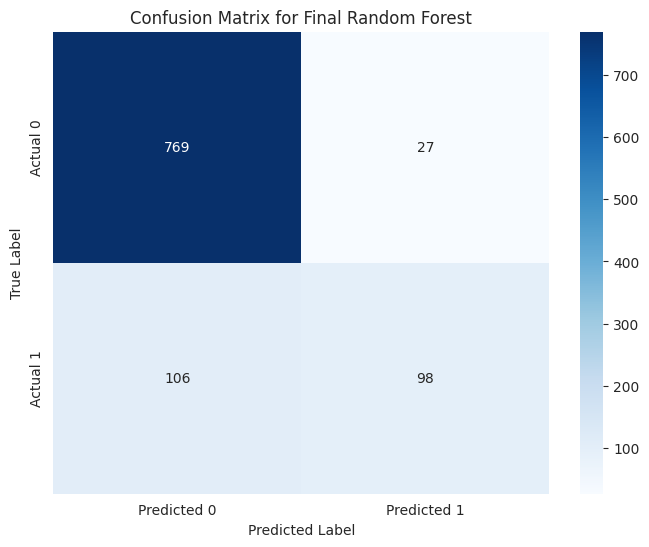

In [237]:
# Plotting the confusion matrix.

plot_confusion_matrix(y_val, final_forest_pred, 'Final Random Forest')

In [238]:
# Observing feature importances.

final_forest.feature_importances_

array([0.03642604, 0.01167915, 0.41775439, 0.01320895, 0.0471983 ,
       0.28801961, 0.00109691, 0.12884395, 0.00231094, 0.00374326,
       0.04642288, 0.00329561])

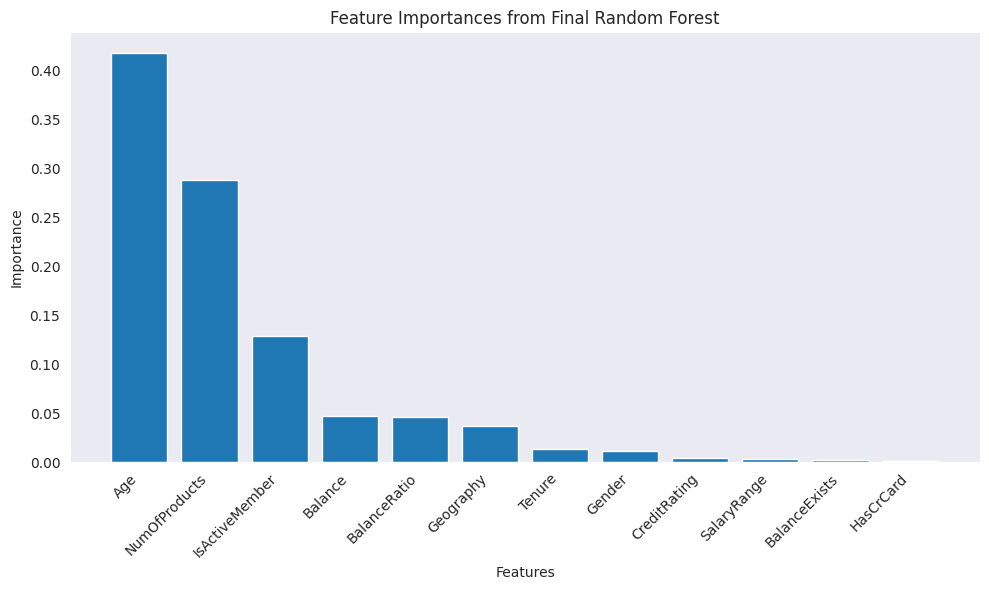

In [239]:
# Plotting feature importances.

plot_feature_importances(final_forest, header_dict, 'Final Random Forest')

In [240]:
# Observing changes in metrics.

model_metrics_with_changes(base_forest, final_forest, X_train, y_train, X_val, y_val)

print(f'Feature Importances: {final_forest.feature_importances_ - base_forest.feature_importances_}')

Change from Base Model

-----

Training Accuracy: -0.131
Validation Accuracy: 0.011
ROC AUC: 0.011
Precision: 0.057
Recall: 0.010

-----

[[ 9 -9]
 [-2  2]]

-----

Feature Importances: [-0.00601174 -0.01101933  0.14980255 -0.08919813 -0.08272762  0.15333283
 -0.02186622  0.08893657 -0.00449938 -0.05805402 -0.07203476 -0.04666074]


### Comments

Similar to the Decision Tree model, the Random Forest has focused primarily on Age and NumOfProducts, but the importances of the other features are noticeably lower and the overreliance on the two core features is higher. Balance and BalanceRatio are nowhere near as important and IsActiveMember is rather the third-most important feature. This is likely due to the randomness of the features being demanded to build each forest. Some features may have significantly less importance than others, but the Random Forest model is forced to use at least some of them for improving accuracy.

The tuning has reduced the training score by 0.131 but made negligible improvements in validation score and recall. We can see from the confusion matrices that the TPs are lower than the Decision Tree (98 vs 111) and the FNs are higher (106 vs 93). The Random Forest model also performs poorer on the validation set than the Decision Tree.

Let us now explore whether feedforward neural networks can be used to differentiate between the two.

# Deep Neural Networks

Here we will use keras to develop some neural network models to experiment with deep learning and see if we can improve upon the previous recall scores. The Decision Tree Classifier yielded a final recall 0.485 and the Random Forest Classifier yielded 0.490. The goal of the neural networks is to beat these two benchmarks.

We will first establish a base neural network model, much like what was done above with Decision Trees and Random Forests. The data has already been preprocessed with the MinMaxScaler, which is recommended for neural network processing. TensorFlow will be used to create Datasets and batch sizes will be set to a base value of 32.

The basic neural network model will use an input layer of 10 neurons (for each feature), two hidden layers of 16 neurons, and a final output layer of 1 neuron. The hidden layers will both use a RELU activation, which has been proven to converge at a high speed for most data structures. The final layer will be a sigmoid activation to distinguish between the likelihood of churn (1) or not-churn (0).

The model will be trained using an ADAM optimizer and the loss will be calculated using Binary Cross Entropy. Hyperparameters to be explored include model depth, model breadth, activation functions, dropout layers and batch size.

## Functions

In [57]:
# Function to create datasets and establish batch sizes.

def create_datasets(X_train, y_train, X_val, y_val, batch_size):

  # Creating the training dataset.
  features = tf.data.Dataset.from_tensor_slices(X_train)
  labels = tf.data.Dataset.from_tensor_slices(y_train)
  training_dataset = tf.data.Dataset.zip((features, labels))

  # Creating the validation dataset.
  val_features = tf.data.Dataset.from_tensor_slices(X_val)
  val_labels = tf.data.Dataset.from_tensor_slices(y_val)
  validation_dataset = tf.data.Dataset.zip((val_features, val_labels))

  # Shuffling and establishing batch sizes.
  training_dataset = training_dataset.shuffle(buffer_size=1024).batch(batch_size=batch_size)
  validation_dataset = validation_dataset.batch(batch_size=batch_size)

  return training_dataset, validation_dataset

In [58]:
# Function to build and train a model with parameters for epochs, batch size and verbosity.

def train_model(model_architecture, epochs, batch_size, verbosity):

  # Creating new instance of model.
  training_dataset, validation_dataset = create_datasets(X_train, y_train, X_val, y_val, batch_size)
  model = model_architecture()

  # Fitting the model to the datasets.
  history = model.fit(training_dataset, validation_data=validation_dataset, epochs=epochs, verbose=verbosity)

  return history

In [59]:
# Plotting history of loss and recall for a model.

def plot_history(history, title):

  # Distinguishing between training and validation losses and recalls.
  acc = history.history['recall']
  val_acc = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  # Plotting the figures.
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  fig.suptitle(f'Training Loss & Recall for {title}')

  for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Recall", "Loss"])):
      ax[i].plot(epochs, data[0], 'r', label="Training " + label)
      ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
      ax[i].legend()
      ax[i].set_xlabel('epochs')

  plt.show()

## Basic Model

In [60]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [61]:
def basic_model():

  # Establishing a basic model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [62]:
# Examining model parameters.

test_model = basic_model()
test_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
%%time

# Training model.

basic_model_history = train_model(basic_model, 100, 32, 0)

CPU times: user 1min 20s, sys: 2.73 s, total: 1min 22s
Wall time: 1min 35s


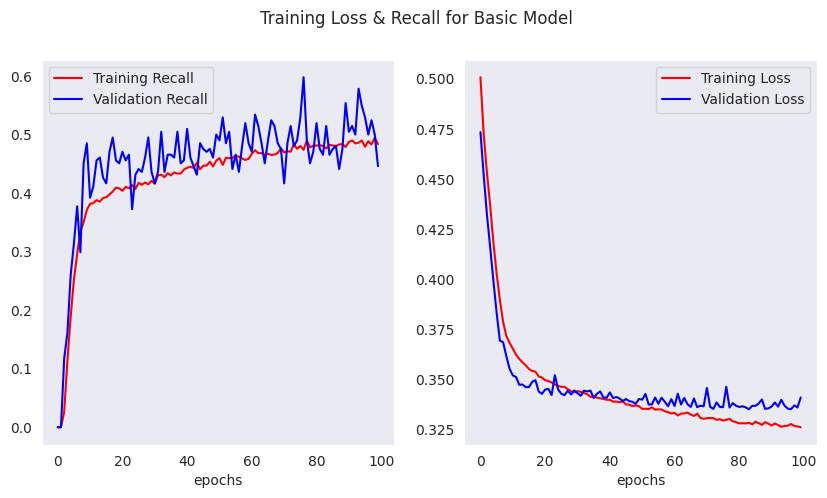

In [64]:
plot_history(basic_model_history, 'Basic Model')

### Comments

Validation loss plateaus a bit after 40 epochs. It hovers around 0.350 for the final 60 epochs. This model can be used as a bench mark for various architectures going forward.

Note that the validation recall tends to be erratic but generall trending in the right direction.

## Exploring Model Depth

In [65]:
def deep_model():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [66]:
# Examining model parameters.

test_model = deep_model()
test_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
%%time

# Training model.

deep_model_history = train_model(deep_model, 100, 32, 0)

CPU times: user 1min 17s, sys: 2.85 s, total: 1min 20s
Wall time: 1min 13s


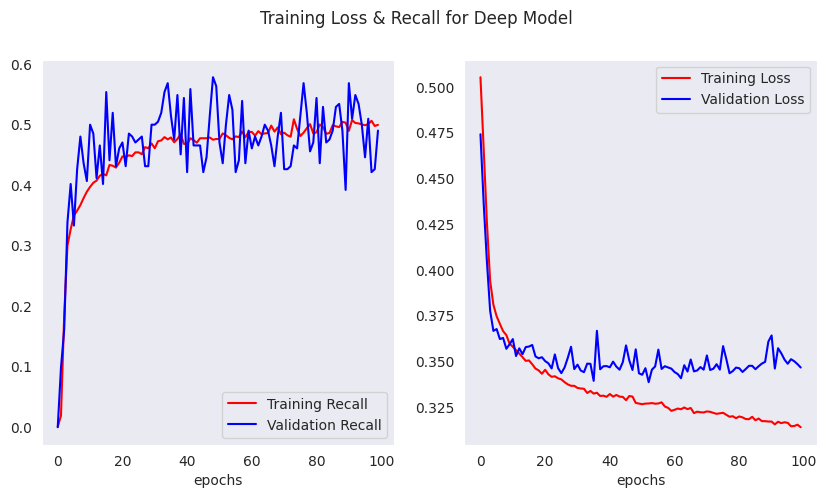

In [68]:
plot_history(deep_model_history, 'Deep Model')

### Comments

This model used four hidden layers rather than just two. The number of neurons was maintained at 16 for the two extra hidden layers. We can see that the model begins to overfit the data after the 20th epoch. The training loss begins to noticeably decrease but the validation loss remains relatively constant. As far as validation loss goes, there isn't much of an improvement on the previous model. The training recall is relatively stable but the validation recall remains highly erratic.

## Exploring Model Breadth

In [69]:
def broad_model():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [70]:
# Examining model parameters.

test_model = broad_model()
test_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,377 (271.00 KB)

 Trainable params: 69,377 (271.00 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
%%time

# Training model.

broad_model_history = train_model(broad_model, 100, 32, 0)

CPU times: user 2min 1s, sys: 6.24 s, total: 2min 7s
Wall time: 1min 53s


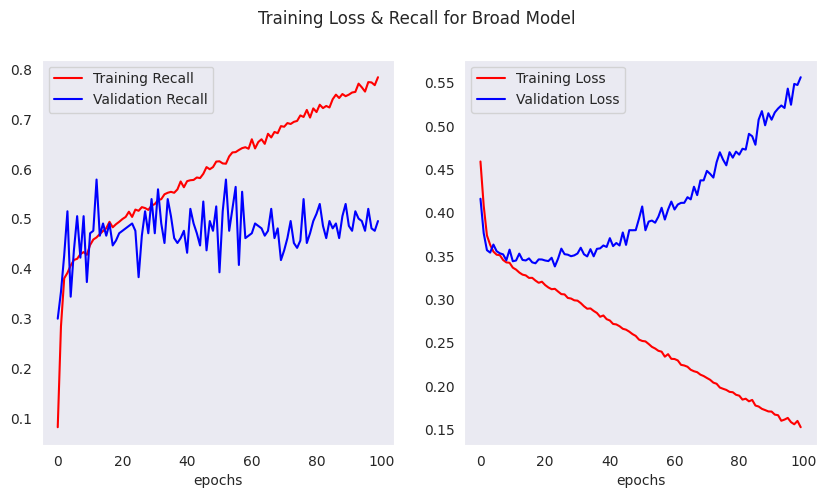

In [72]:
plot_history(broad_model_history, 'Broad Model')

### Comments

This architecture maintains two hidden layers but increases the number of neurons of both layers to 256. The intention is to see if the addition of neurons is able to capture more complex relationships between the features.

The validation loss reaches 0.35 by the 20th epoch but rises earlier steeply afterwards. It reaches to roughly 0.55 by the end. As we can see, the broader model is highly prone to overfitting. It may be possible to mitigate this through Dropout layers which force the model to restructure its neural connections to more efficacious ones. This will be explored further later.

## Combining Increased Depth with Increased Breadth

In [73]:
def mixed_model_1():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [74]:
def mixed_model_2():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [75]:
# Examining model parameters.

test_model = mixed_model_1()
test_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,673 (18.25 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Examining model parameters.

test_model = mixed_model_2()
test_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,329 (200.50 KB)

 Trainable params: 51,329 (200.50 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
%%time

# Training model.

mixed_model_1_history = train_model(mixed_model_1, 100, 32, 0)

CPU times: user 1min 21s, sys: 2.96 s, total: 1min 24s
Wall time: 1min 13s


In [78]:
%%time

# Training model.

mixed_model_2_history = train_model(mixed_model_2, 100, 32, 0)

CPU times: user 1min 40s, sys: 3.38 s, total: 1min 44s
Wall time: 1min 36s


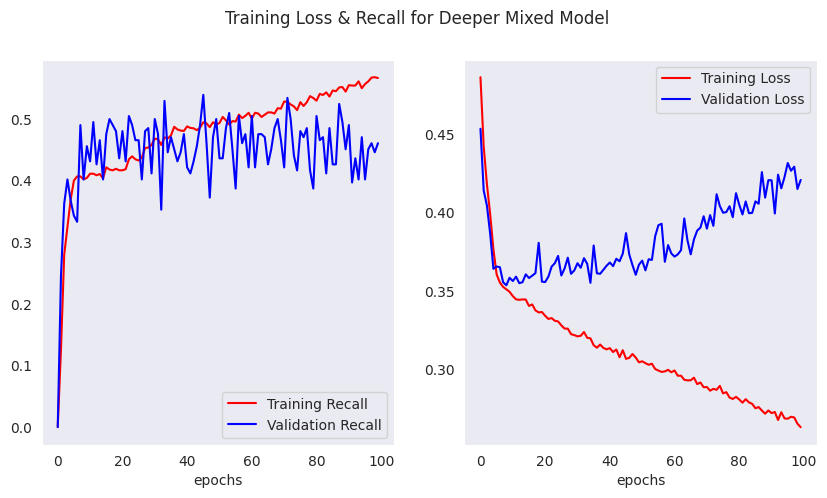

In [79]:
plot_history(mixed_model_1_history, 'Deeper Mixed Model')

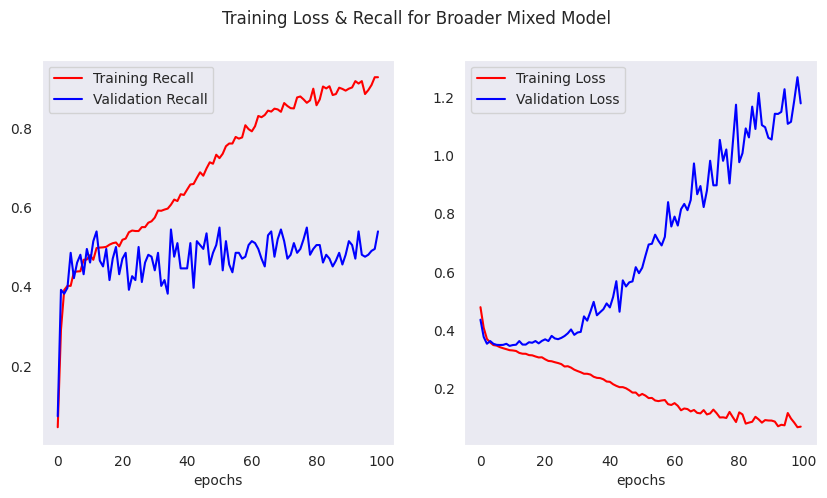

In [80]:
plot_history(mixed_model_2_history, 'Broader Mixed Model')

### Comments

Two mixed models were looked at: Model 1 is more deep than broad whereas Model 2 is more broad than deep. Much like the previous instances, the mixed model visibly overfits within 100 epochs. Model 1 reaches a validation loss of 0.400 after 100 epochs while Model 2 reaches 1.200. It appears that adding model breadth is more conducive to overfitting than model depth, hence it may be argued that this dataset requires a narrow neural network to achieve a high accuracy.

We will attempt to mitigate the overfitting for deeper structures in the following subsections by exploring changes in the activation function, the batch size and some dropout layers.

## Exploring L1 Regularization

Here we will take a look at L1 regularization, which adds an absolute sum of the weights to the cost function and consequently pushes some of the feature importances to zero. L1 regularization can be thought of as a form of "feature selection" with neurons. We already saw with the Decision Tree model that an accurate model does not necessarily require all features to be used. We will see here if the same applies to neural connections.

In [81]:
def l1_model(reg_value):

  # Establishing a basic model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(reg_value)),
      tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(reg_value)),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [82]:
# Examining model parameters.

test_model = l1_model(0.1)
test_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

Regularization Value: 0.0001



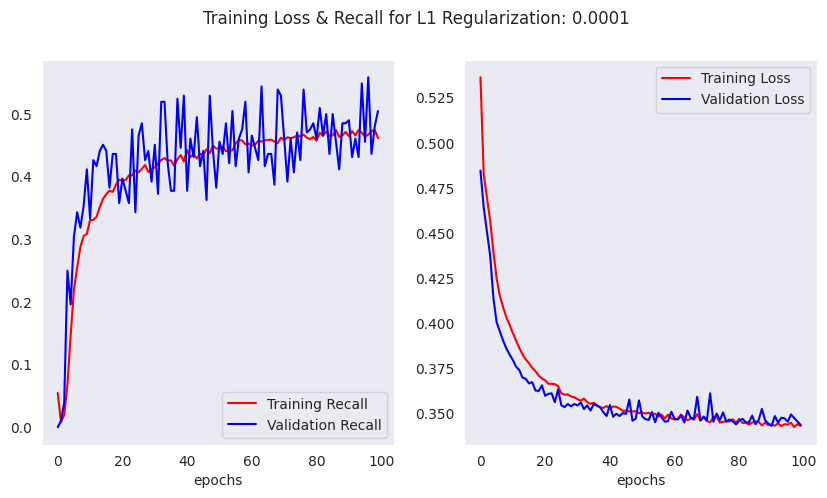


-----

Regularization Value: 0.0002



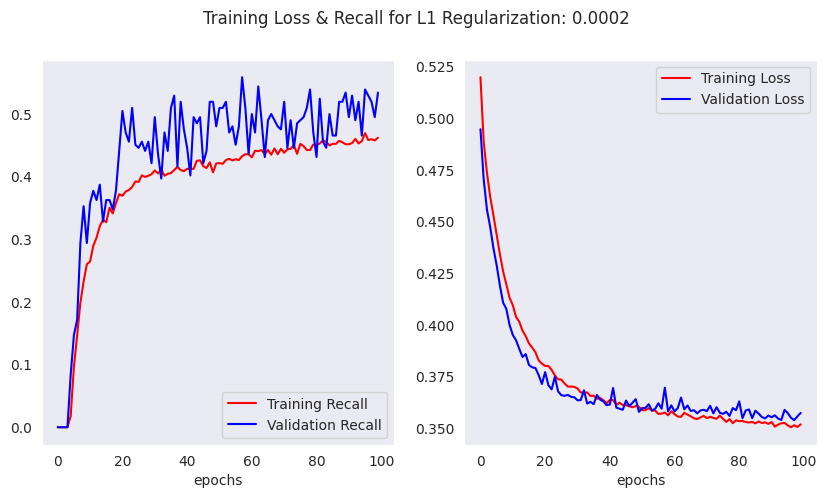


-----

Regularization Value: 0.0005



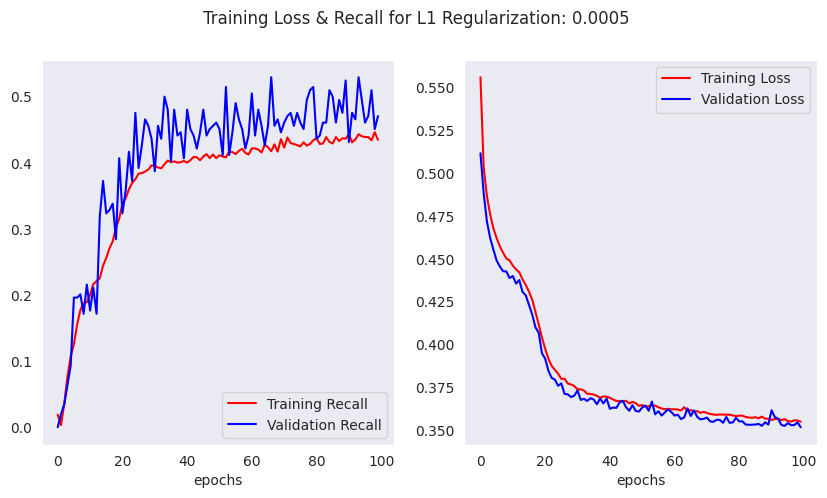


-----

Regularization Value: 0.001



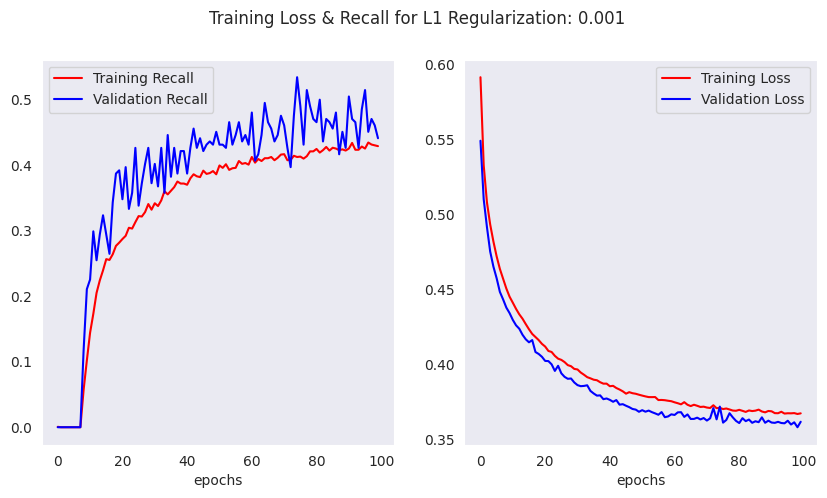


-----

Regularization Value: 0.0025



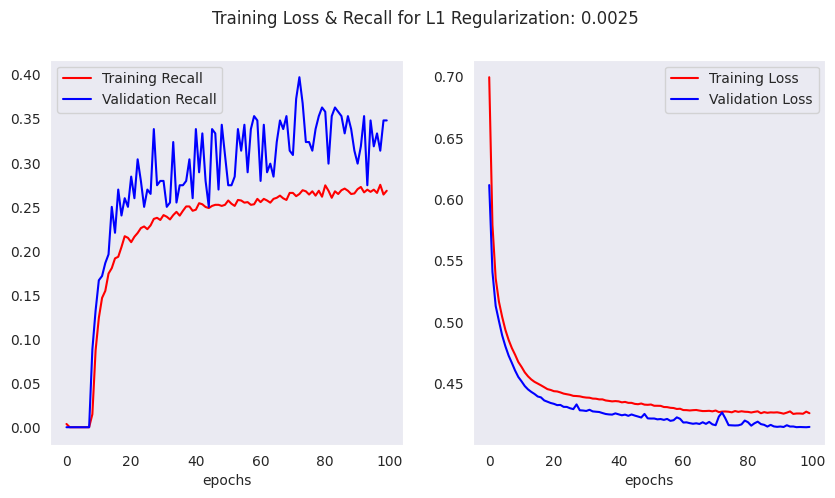


-----

CPU times: user 6min 4s, sys: 13.4 s, total: 6min 17s
Wall time: 5min 34s


In [83]:
%%time

# Examining loss and recall for a range of regularization values.

reg_values = [0.0001, 0.0002, 0.0005, 0.001, 0.0025]

for reg_value in reg_values:
  print(f"Regularization Value: {reg_value}\n")

  l1_model_history = train_model(lambda: l1_model(reg_value), 100, 32, 0)
  plot_history(l1_model_history, f'L1 Regularization: {reg_value}')
  print('\n-----\n')

While L1 regularization certainly smoothes out the losses, the validation loss steadily increases with the L1 value. It might only be possible to include L1 regularization with a very low value of L1 and observe  loss with greater epochs.

## Exploring Activation Functions

The previous models had all used RELU functions in the hidden layers. RELU was chosen due to its robustness across a variety of models. RELU's weakness, however, is that all logits below zero are set to simply zero. Hence no gradient optimization can be done for negative values of z=wx+b. As a result, three additional activation functions will be looked at here.

The Exponential Linear Unit (ELU) function set the negative activation to alpha * (exp(x) - 1), which steadily converges to a value of -1. Its positive activation value is simply z (the same as RELU). This choice of negative activation function is expected to steadily push the mean of the activation values to zero, thereby pushing the gradient closer to the "true gradient" than would otherwise happen with RELU.

The Sigmoid-Weighted Linear Unit (SILU, also known as Swish) has an activation function of x * sigmoid(x). The activation values function very similarly to a RELU but has an activation value which dips into the negative before converging to zero from the bottom. The Gaussian Error Linear Unit (GELU) functions similarly to SILU but the activation function is multiplied with phi(x), where phi is the standard Gaussian cumulative distribution.

### Basic Model with ELU

In [84]:
def basic_elu_model():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [85]:
# Examining model parameters.

test_model = basic_elu_model()
test_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
%%time

# Training model.

basic_elu_model_history = train_model(basic_elu_model, 100, 32, 0)

CPU times: user 1min 10s, sys: 2.62 s, total: 1min 12s
Wall time: 1min 3s


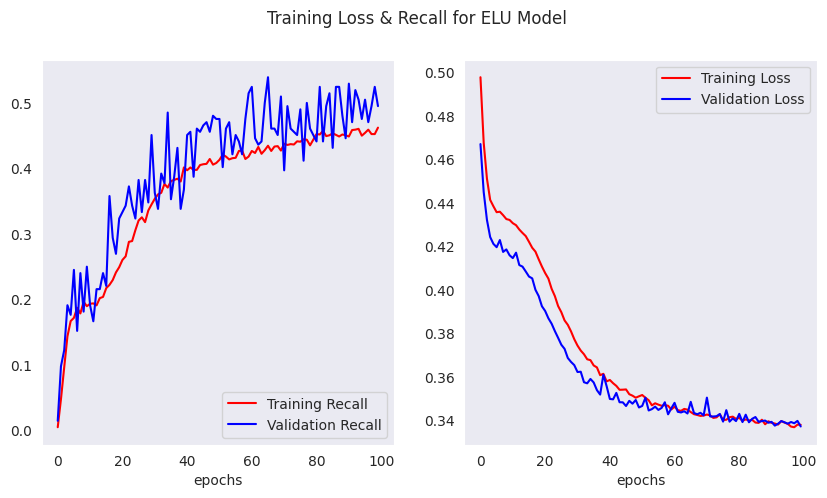

In [87]:
plot_history(basic_elu_model_history, 'ELU Model')

### Basic Model with GELU

In [88]:
def basic_gelu_model():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [89]:
# Examining model parameters.

test_model = basic_gelu_model()
test_model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
%%time

# Training model.

basic_gelu_model_history = train_model(basic_gelu_model, 100, 32, 0)

CPU times: user 1min 10s, sys: 2.62 s, total: 1min 12s
Wall time: 1min 1s


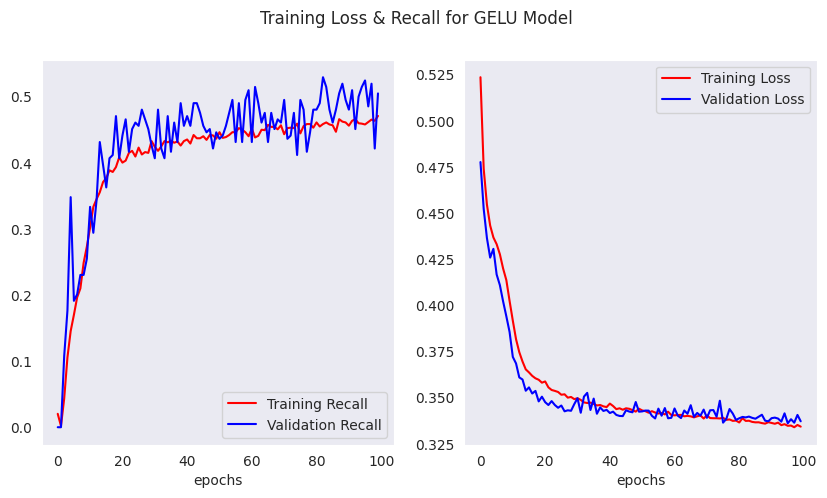

In [91]:
plot_history(basic_gelu_model_history, 'GELU Model')

### Basic Model with SILU

In [92]:
def basic_silu_model():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [93]:
# Examining model parameters.

test_model = basic_silu_model()
test_model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
%%time

# Training model.

basic_silu_model_history = train_model(basic_silu_model, 100, 32, 0)

CPU times: user 1min 10s, sys: 2.8 s, total: 1min 13s
Wall time: 1min 3s


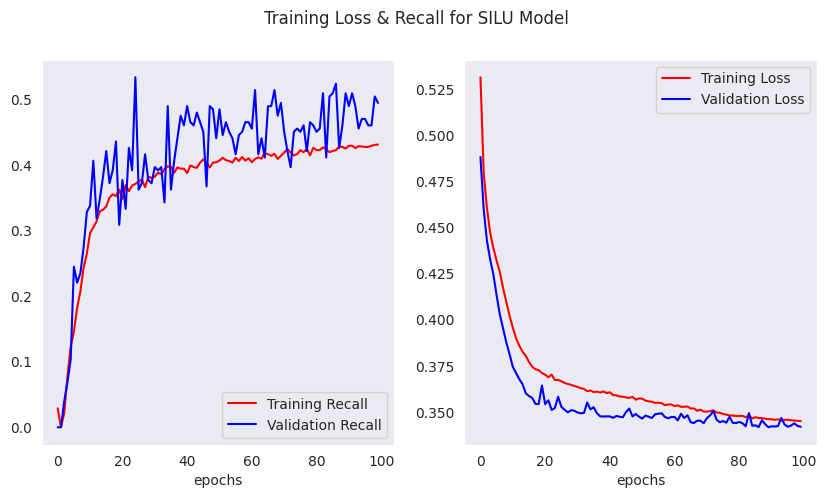

In [95]:
plot_history(basic_silu_model_history, 'SILU Model')

### Comments

All three models perform quite well and are similar to the basic RELU model. Differences will likely only be seen once the models are trained for extended periods.

### Deep Model with ELU

In [96]:
def deep_elu_model():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [97]:
# Examining model parameters.

test_model = deep_elu_model()
test_model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
%%time

# Training model.

deep_elu_model_history = train_model(deep_elu_model, 100, 32, 0)

CPU times: user 1min 17s, sys: 2.86 s, total: 1min 20s
Wall time: 1min 9s


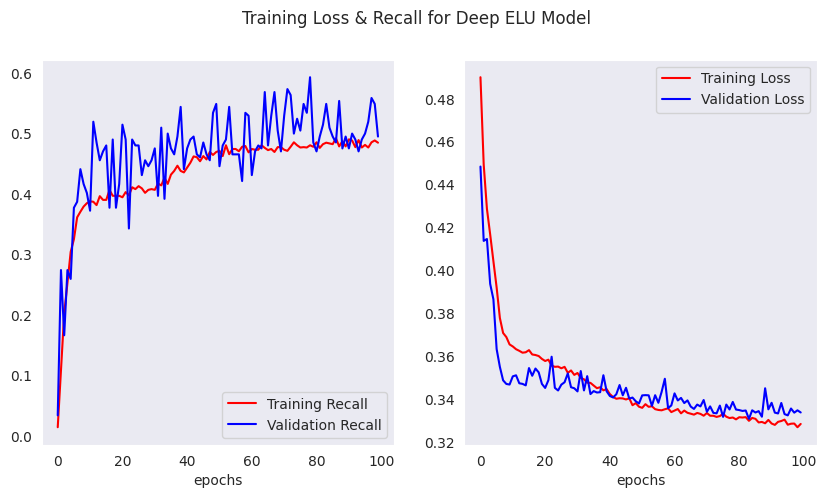

In [99]:
plot_history(deep_elu_model_history, 'Deep ELU Model')

### Deep Model with GELU

In [100]:
def deep_gelu_model():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [101]:
# Examining model parameters.

test_model = deep_gelu_model()
test_model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
%%time

# Training model.

deep_gelu_model_history = train_model(deep_gelu_model, 100, 32, 0)

CPU times: user 1min 21s, sys: 3.08 s, total: 1min 24s
Wall time: 1min 19s


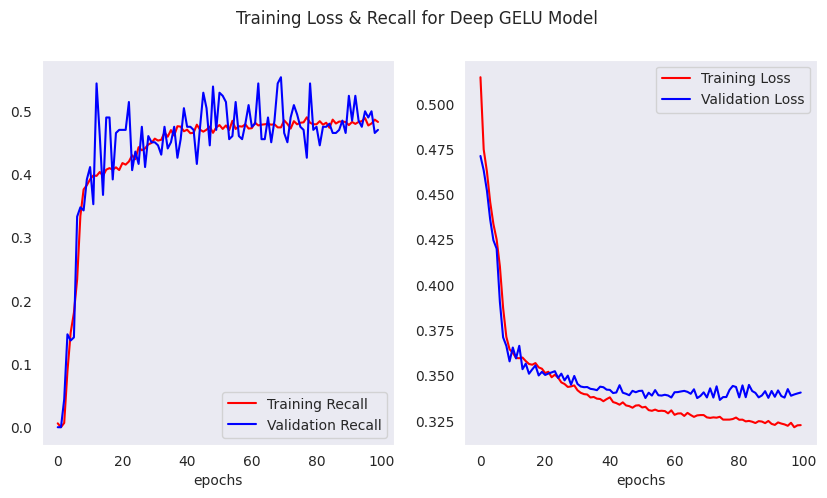

In [103]:
plot_history(deep_gelu_model_history, 'Deep GELU Model')

### Deep Model with SILU

In [104]:
def deep_silu_model():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [105]:
# Examining model parameters.

test_model = deep_silu_model()
test_model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
%%time

# Training model.

deep_silu_model_history = train_model(deep_silu_model, 100, 32, 0)

CPU times: user 1min 18s, sys: 2.89 s, total: 1min 21s
Wall time: 1min 8s


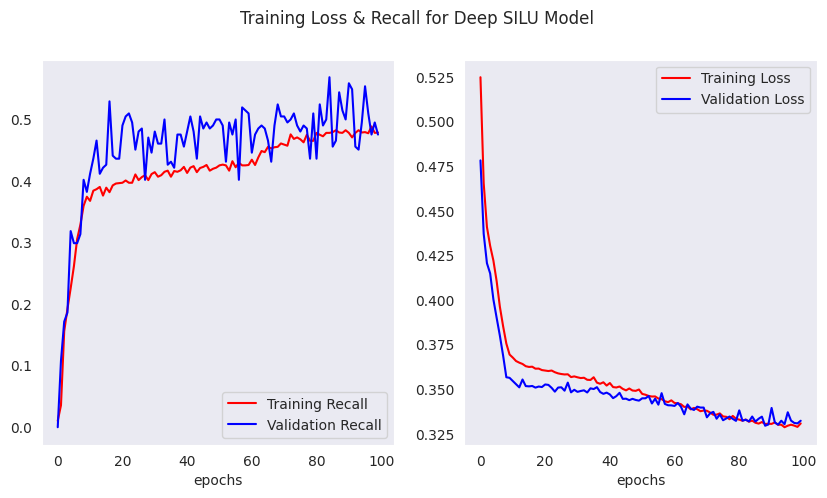

In [107]:
plot_history(deep_silu_model_history, 'Deep SILU Model')

### Comments

All three models respond well to increased depth. None of the show signs of overfitting. The GELU model appears to respond the best.

## Exploring Various Batch Sizes

Although various batch sizes are recommended, we will solely experiment with sizes 16, 32, 64, and 128 since we only have 8000 training examples. The deep SILU model seems to achieve the lowest validation loss, so it will be the model of choice going forward.

Batch Size: 16



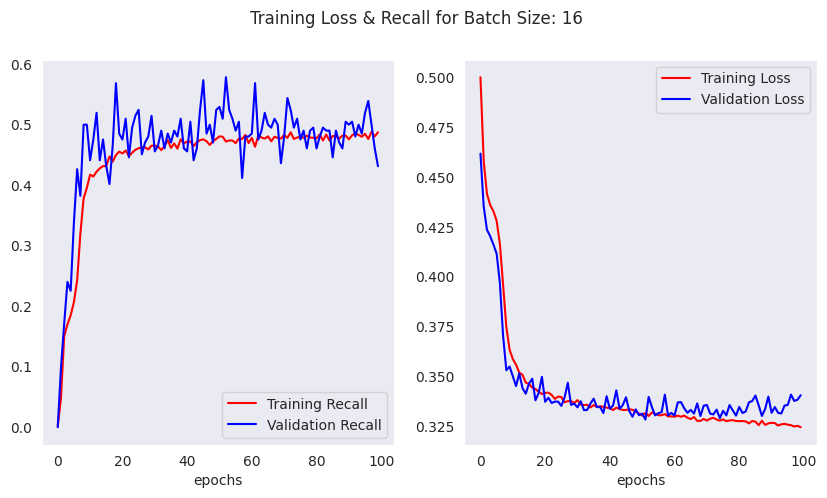


-----

Batch Size: 32



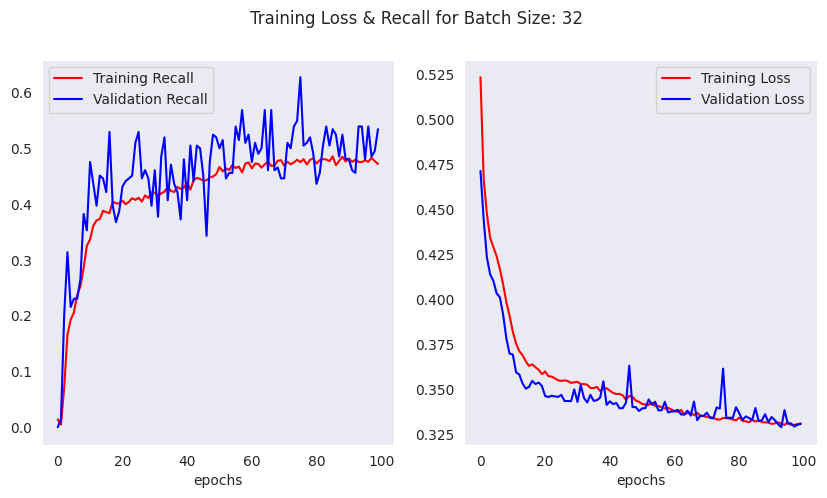


-----

Batch Size: 64



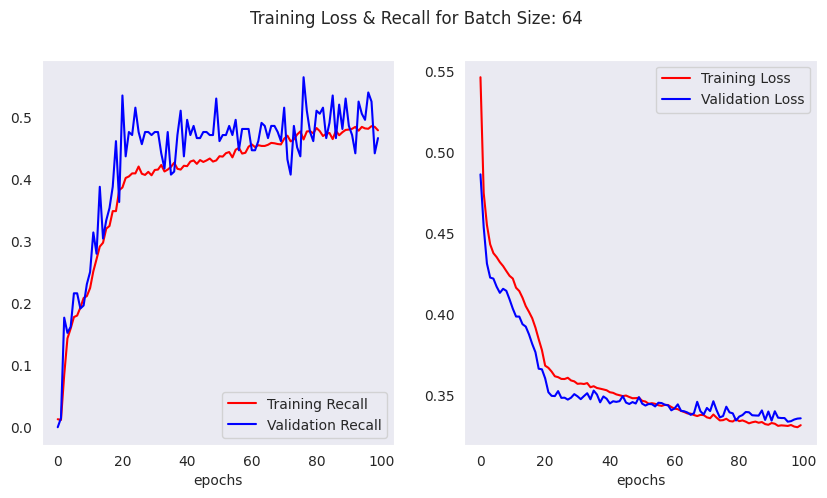


-----

Batch Size: 128



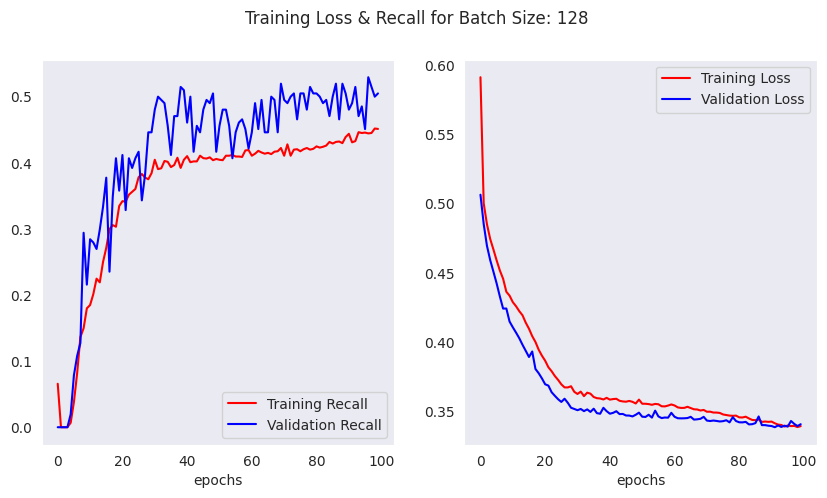


-----

Batch Size: 256



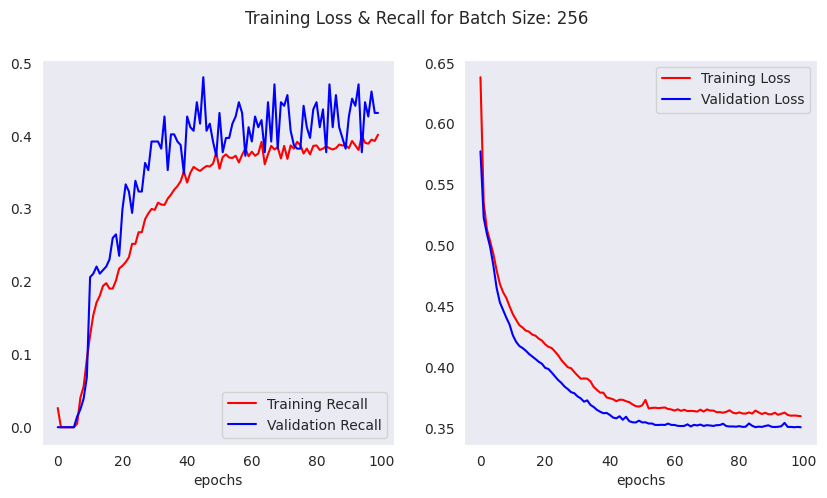


-----

CPU times: user 5min 16s, sys: 12.1 s, total: 5min 28s
Wall time: 4min 47s


In [108]:
%%time

# Examining loss and recall for a range of batch sizes.

batch_sizes = [16, 32, 64, 128, 256]

for batch_size in batch_sizes:
  print(f"Batch Size: {batch_size}\n")
  history = train_model(deep_silu_model, 100, batch_size, 0)
  plot_history(history, f'Batch Size: {batch_size}')
  print('\n-----\n')

### Comments

Batch sizes of 32 or 64 are probably best with 16 being a probable choice. Batches of 128 or 256 are too large for this dataset and risk being stuck inside a local minima, although the graphs are quite smooth.

## Exploring Dropout Layers

In [114]:
def deep_gelu_model_with_dropout(input_dropout, hidden_dropout):

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dropout(input_dropout),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dropout(hidden_dropout),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dropout(hidden_dropout),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dropout(hidden_dropout),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dropout(hidden_dropout),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [115]:
# Examining model parameters.

test_model = deep_gelu_model_with_dropout(0.1, 0.2)
test_model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
%%time

# Training model over 250 epochs.

deep_gelu_model_with_dropout_history = train_model(lambda: deep_gelu_model_with_dropout(0.1, 0.2), 250, 32, 0)

CPU times: user 4min 3s, sys: 7.52 s, total: 4min 10s
Wall time: 4min 36s


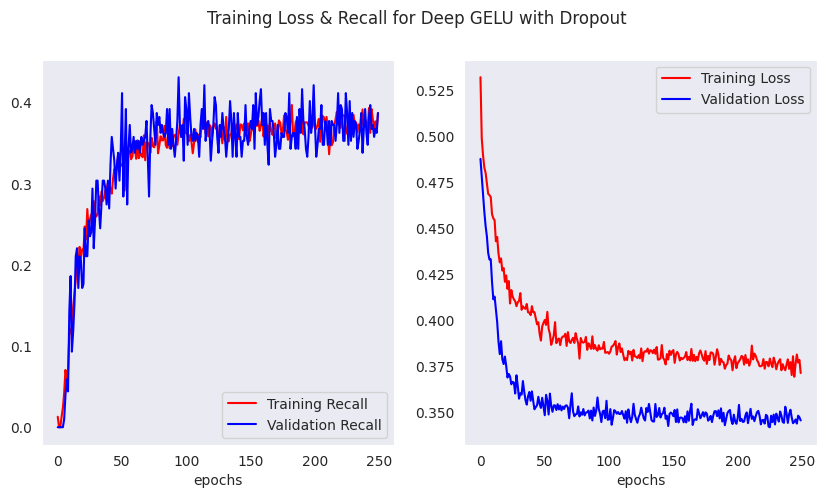

In [117]:
plot_history(deep_gelu_model_with_dropout_history, 'Deep GELU with Dropout')

Batch Size: 32, Input Dropout: 0.1, Hidden Dropout: 0.2



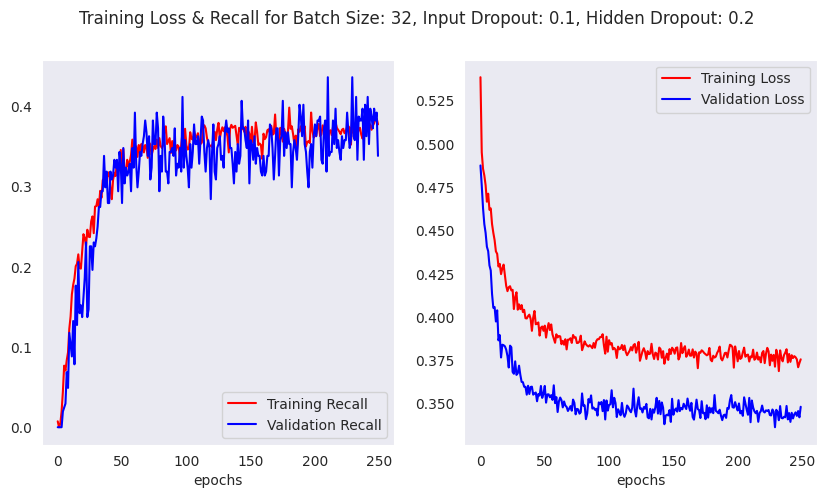


-----

Batch Size: 32, Input Dropout: 0.1, Hidden Dropout: 0.3



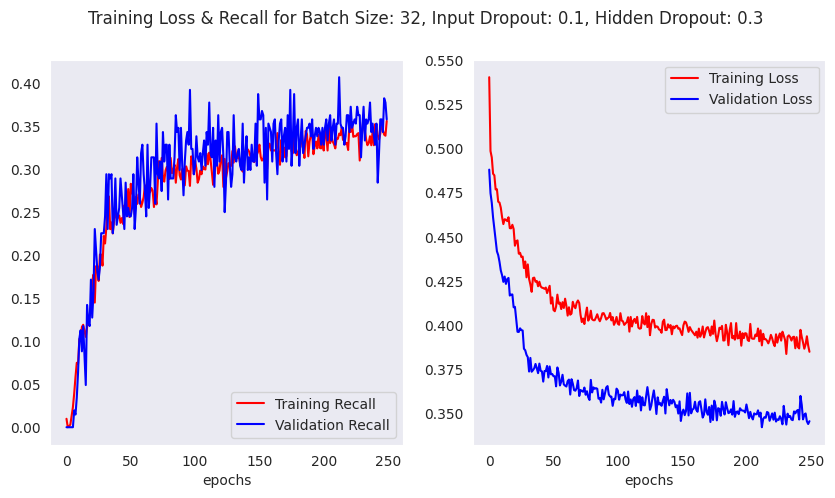


-----

Batch Size: 32, Input Dropout: 0.1, Hidden Dropout: 0.4



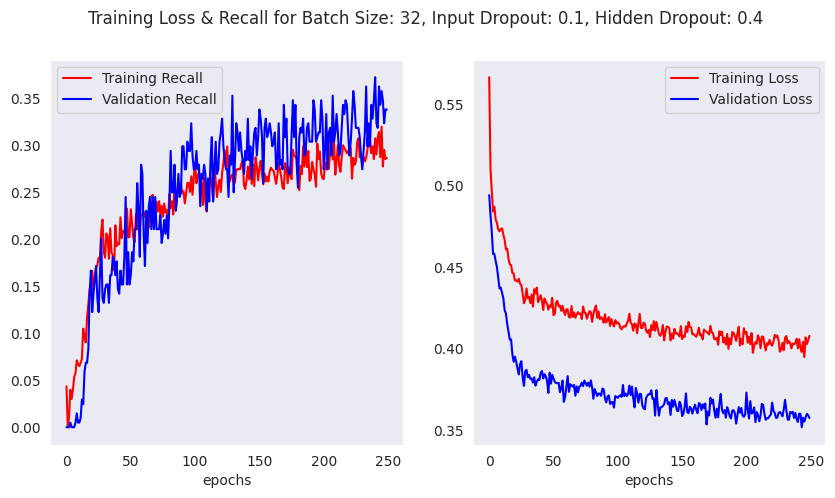


-----

Batch Size: 32, Input Dropout: 0.25, Hidden Dropout: 0.2



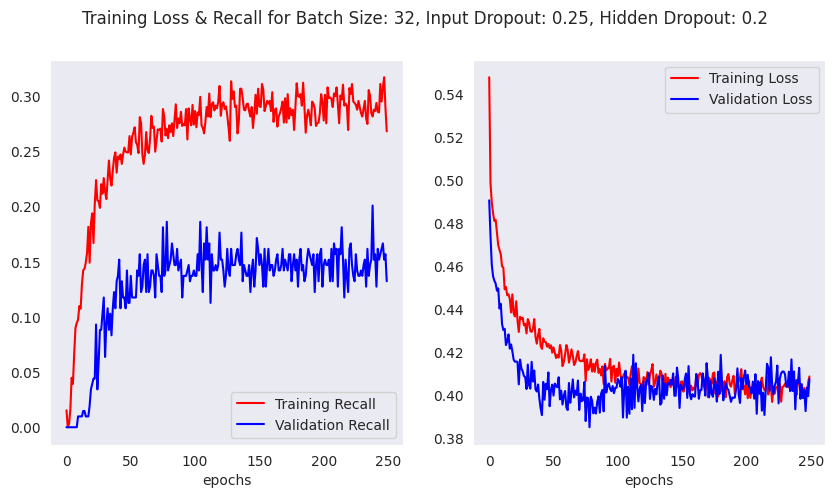


-----

Batch Size: 32, Input Dropout: 0.25, Hidden Dropout: 0.3



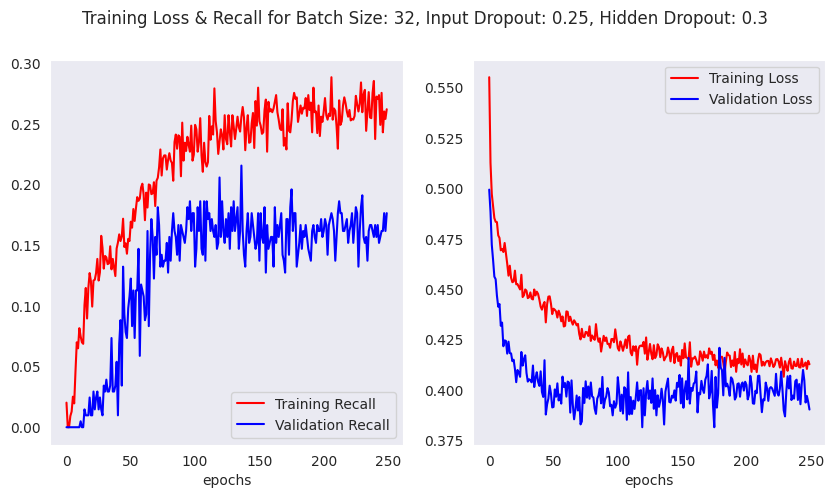


-----

Batch Size: 32, Input Dropout: 0.25, Hidden Dropout: 0.4



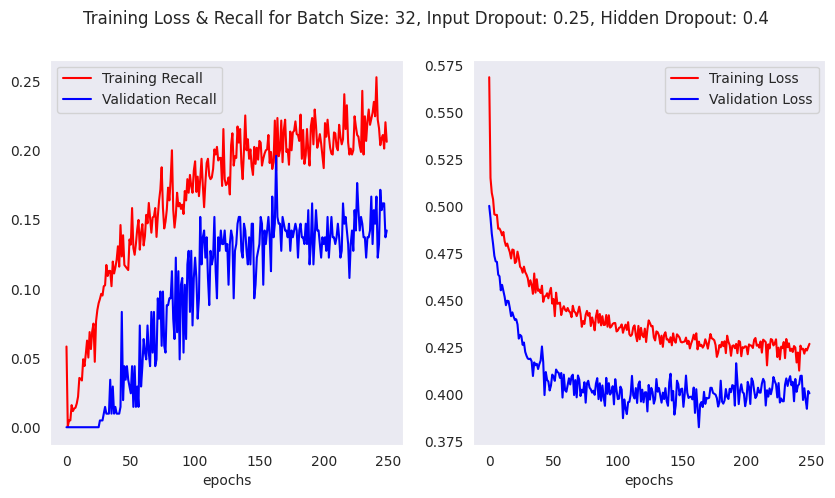


-----

Batch Size: 64, Input Dropout: 0.1, Hidden Dropout: 0.2



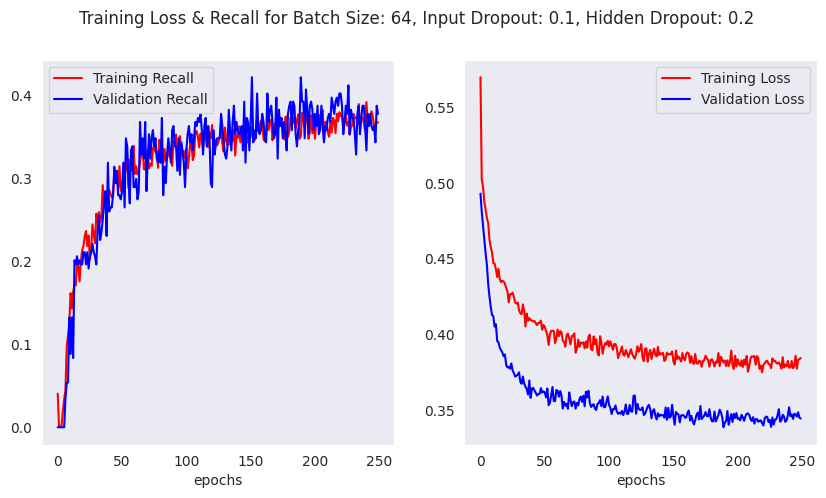


-----

Batch Size: 64, Input Dropout: 0.1, Hidden Dropout: 0.3



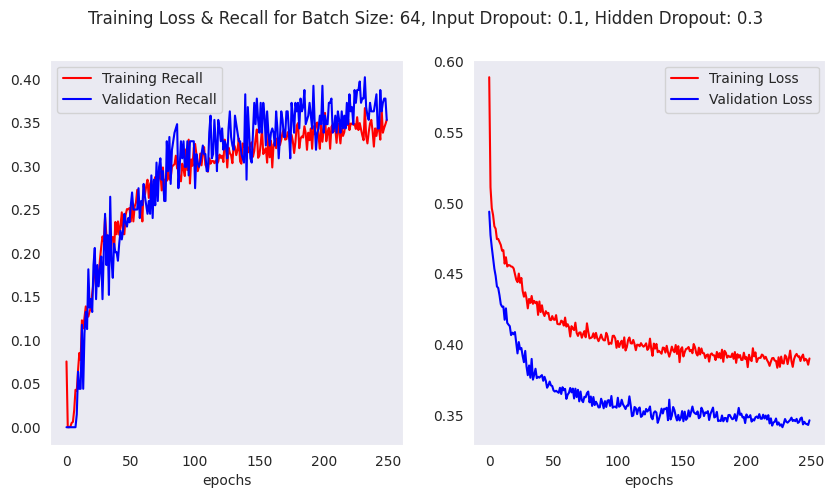


-----

Batch Size: 64, Input Dropout: 0.1, Hidden Dropout: 0.4



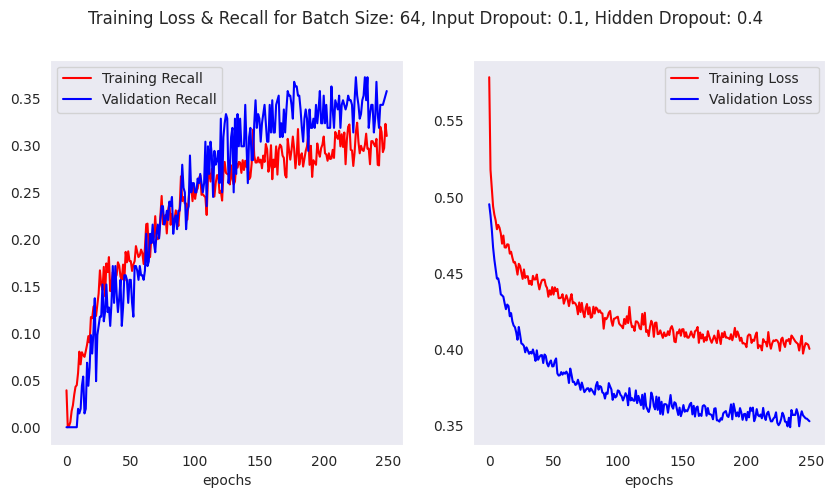


-----

Batch Size: 64, Input Dropout: 0.25, Hidden Dropout: 0.2



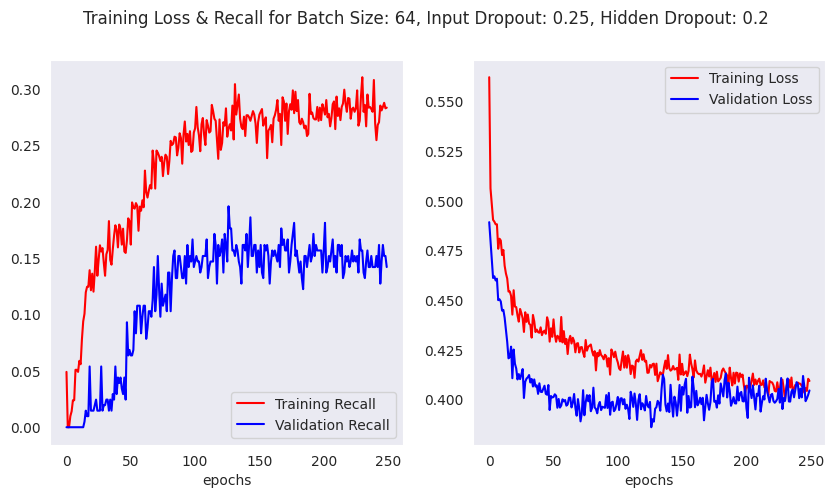


-----

Batch Size: 64, Input Dropout: 0.25, Hidden Dropout: 0.3



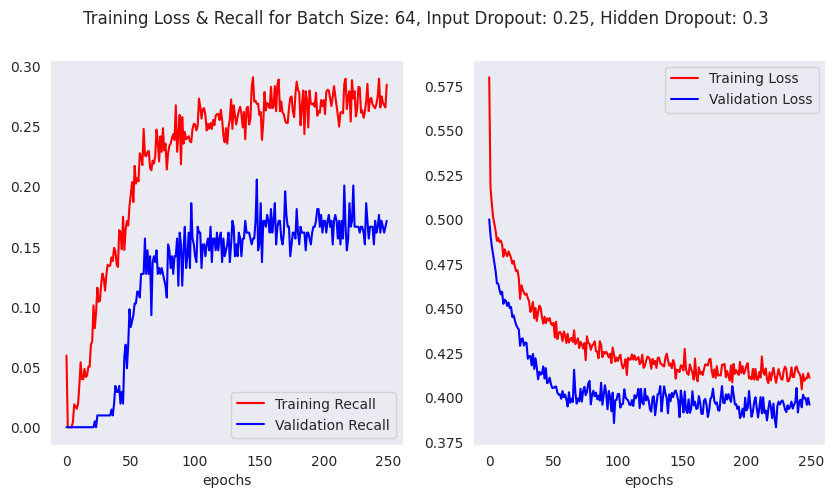


-----

Batch Size: 64, Input Dropout: 0.25, Hidden Dropout: 0.4



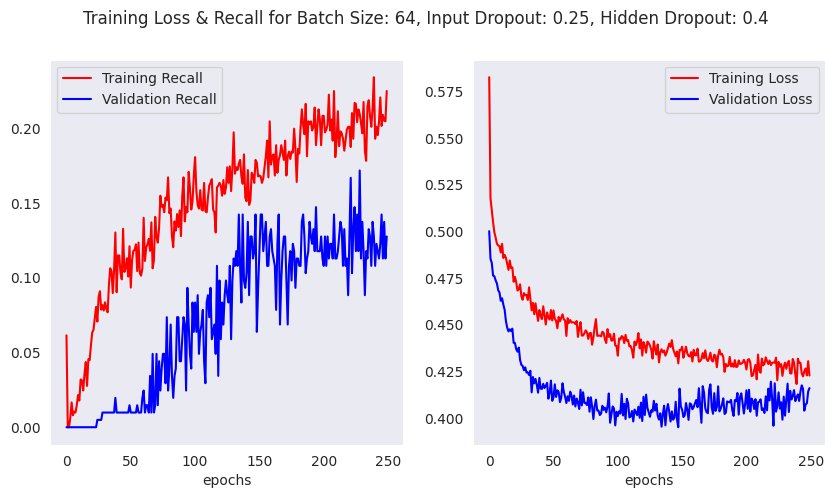


-----

CPU times: user 34min 38s, sys: 1min 11s, total: 35min 49s
Wall time: 31min 49s


In [118]:
%%time

# Examining loss and recall over a range of dropout rates and batch sizes.

batch_sizes = [32, 64]
input_dropout_range = [0.1, 0.25]
hidden_dropout_range = [0.2, 0.3, 0.4]

for batch_size in batch_sizes:
  for input_dropout in input_dropout_range:
    for hidden_dropout in hidden_dropout_range:
      print(f"Batch Size: {batch_size}, Input Dropout: {input_dropout}, Hidden Dropout: {hidden_dropout}\n")
      history = train_model(lambda: deep_gelu_model_with_dropout(input_dropout, hidden_dropout), 250, batch_size, 0)
      plot_history(history, str.format(f'Batch Size: {batch_size}, Input Dropout: {input_dropout}, Hidden Dropout: {hidden_dropout}'))
      print('\n-----\n')

### Comments

Dropout rates seem to be useful at smaller values but don't seem to otherwise lead to lower losses. Batch size of 32 seems to respond better to dropout than 64, but 64 is smoother.

## Training over Longer Epochs

As we have seen above, the broader models seem unable to generalize the model well. Deeper models perform reasonably well so long as the number of neurons remain few in number. All three of ELU, GELU and SILU seem to perform better than RELU, with batch sizes 32 and 64 fitting particularly well. As a result, let us train the following models for 1000 epochs each and record the respective validation losses and accuracy scores.

- 3-layer models with RELU, ELU, GELU & SILU
- 5-layer models with RELU, ELU, GELU & SILU
- 5-layer models with dropout values of (0.1, 0.2)

In [119]:
%%time

# Training models.

basic_model_history = train_model(basic_model, 1000, 32, 0)
basic_elu_model_history = train_model(basic_elu_model, 1000, 32, 0)
basic_gelu_model_history = train_model(basic_gelu_model, 1000, 32, 0)
basic_silu_model_history = train_model(basic_silu_model, 1000, 32, 0)

CPU times: user 44min 56s, sys: 1min 36s, total: 46min 33s
Wall time: 39min 20s


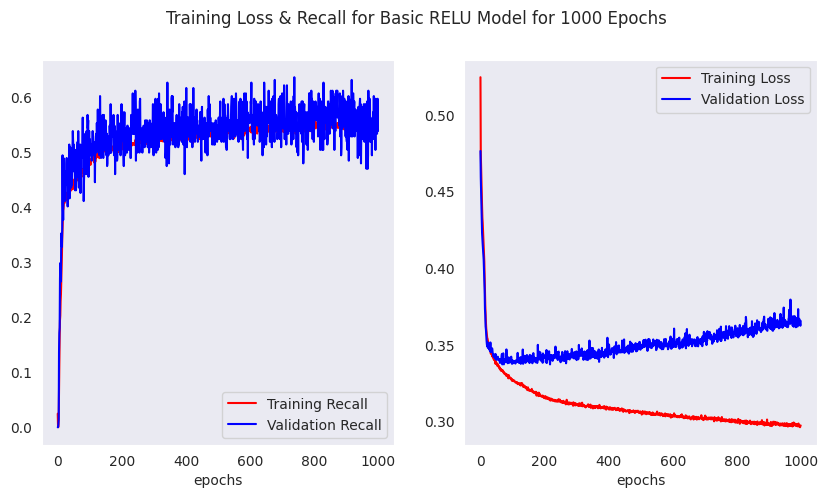

In [120]:
plot_history(basic_model_history, 'Basic RELU Model for 1000 Epochs')

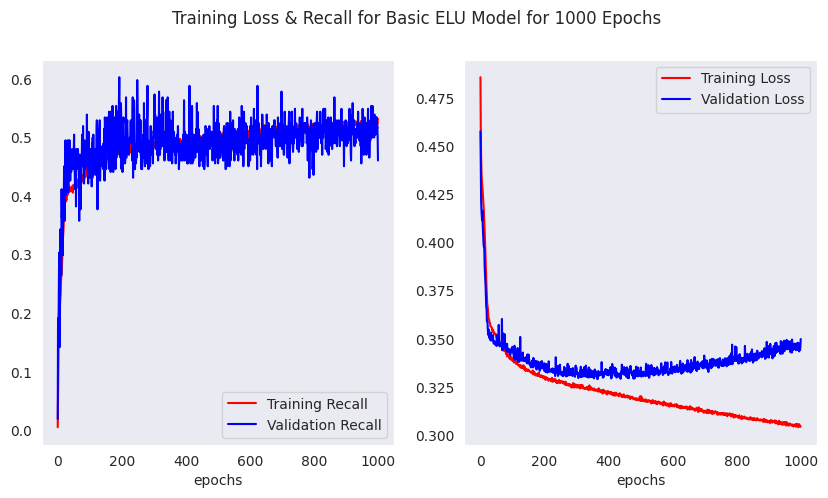

In [121]:
plot_history(basic_elu_model_history, 'Basic ELU Model for 1000 Epochs')

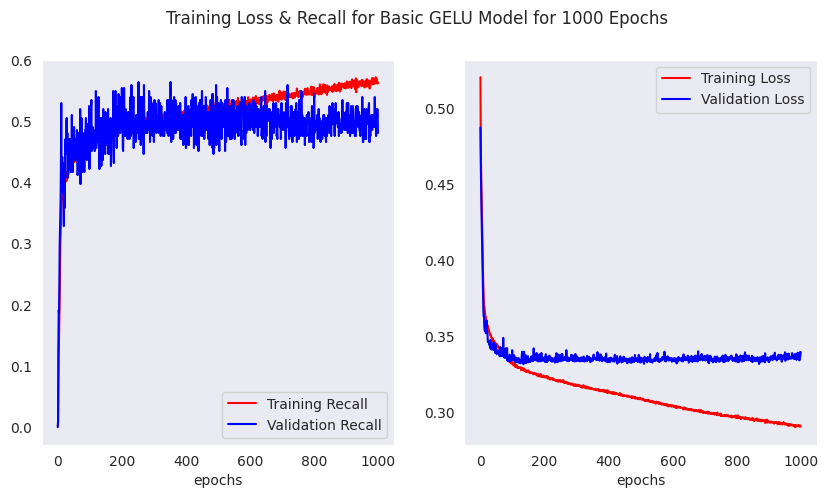

In [122]:
plot_history(basic_gelu_model_history, 'Basic GELU Model for 1000 Epochs')

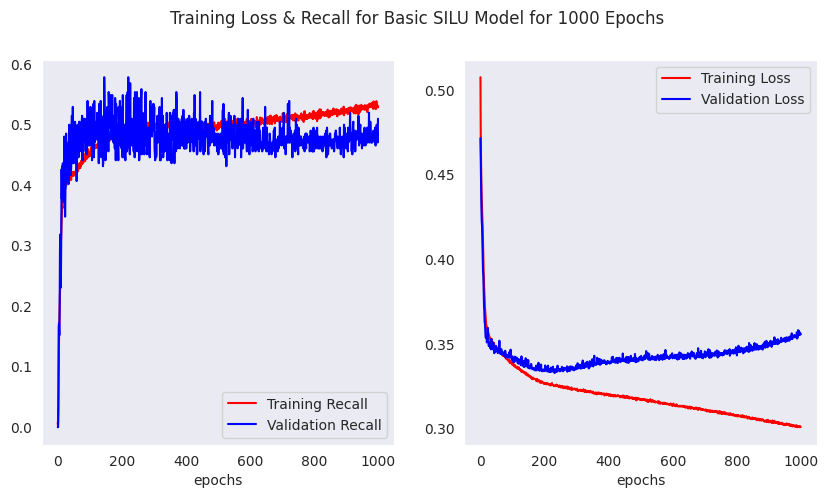

In [123]:
plot_history(basic_silu_model_history, 'Basic SILU Model for 1000 Epochs')

### Comments

The lowest losses seem to occur with batch sizes of 64 and dropout rates of (0.1, 0.1). Both the deep ELU and SILU models seem to converge at roughly 0.340. The basic models with similar dropout rates seems to have a similar convergence. The models with these hyperparameters are also not overfitting. It is possible that a couple of these deeper models might be the most promising one to run for longer epochs and finalize as our ultimate choice.

In [128]:
# Building model.
def deep_gelu_model_with_dropout():

  # Determining model architecture.
  model = tf.keras.models.Sequential([
      tf.keras.Input((12,)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='gelu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model.
  model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [129]:
# Examining model parameters.

test_model = deep_gelu_model_with_dropout()
test_model.summary()

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_95 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 1,041 (4.07 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
%%time

# Training model over 1000 epochs.

deep_gelu_model_with_dropout_history = train_model(deep_gelu_model_with_dropout, 1000, 32, 0)

CPU times: user 15min 2s, sys: 29.4 s, total: 15min 31s
Wall time: 13min 58s


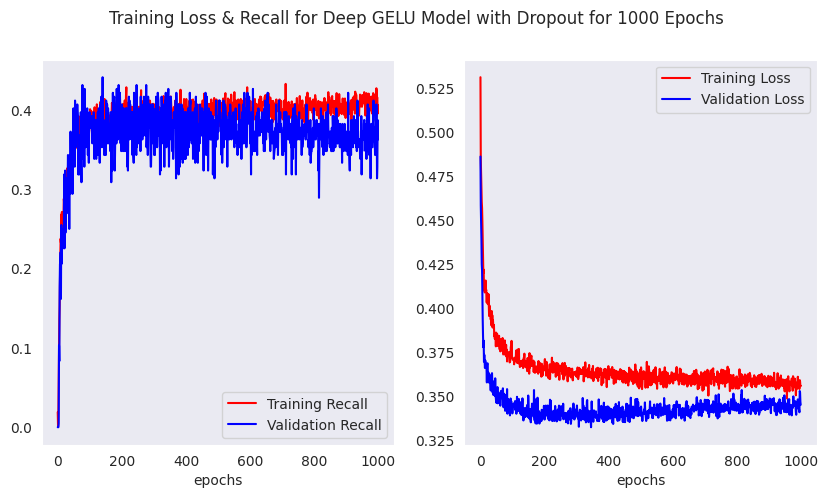

In [131]:
plot_history(deep_gelu_model_with_dropout_history, 'Deep GELU Model with Dropout for 1000 Epochs')

In [132]:
%%time

# Training model over 1000 epochs.

deep_elu_model_history = train_model(deep_elu_model, 1000, 32, 0)

CPU times: user 12min 23s, sys: 24.6 s, total: 12min 47s
Wall time: 10min 46s


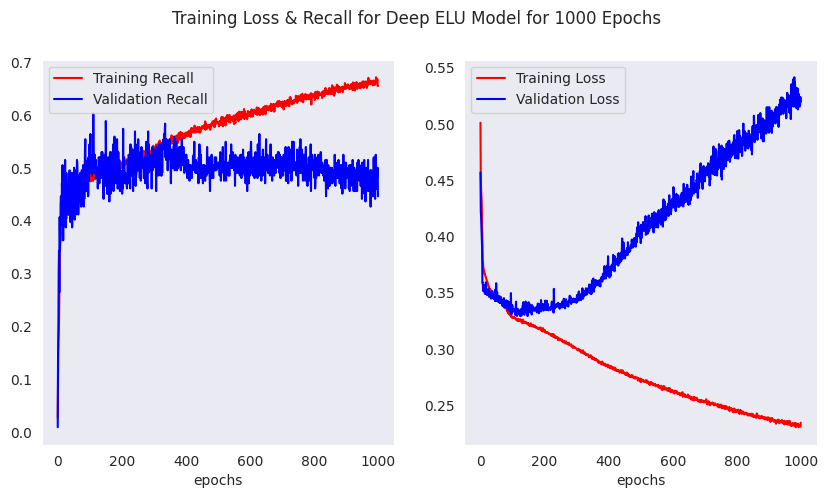

In [133]:
plot_history(deep_elu_model_history, 'Deep ELU Model for 1000 Epochs')

In [134]:
%%time

# Training model over 1000 epochs.

deep_gelu_model_history = train_model(deep_gelu_model, 1000, 32, 0)

CPU times: user 14min 57s, sys: 29.6 s, total: 15min 26s
Wall time: 13min 37s


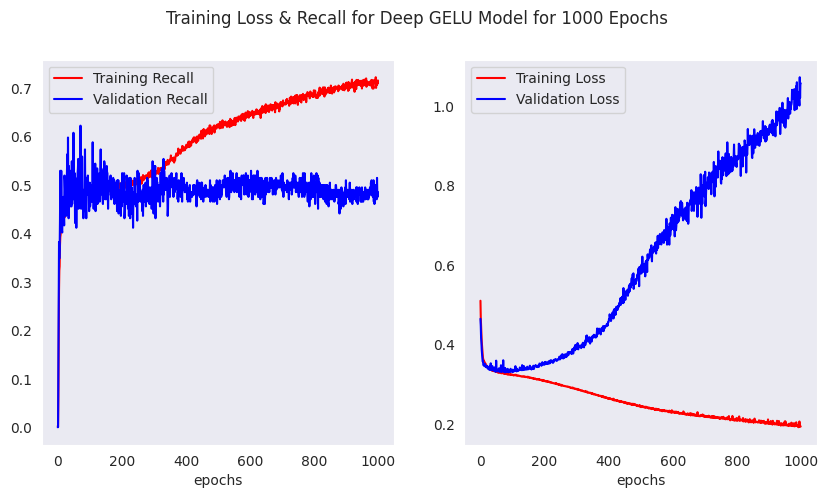

In [135]:
plot_history(deep_gelu_model_history, 'Deep GELU Model for 1000 Epochs')

In [136]:
%%time

# Training model over 1000 epochs.

deep_silu_model_history = train_model(deep_silu_model, 1000, 32, 0)

CPU times: user 15min 42s, sys: 30.1 s, total: 16min 12s
Wall time: 14min 46s


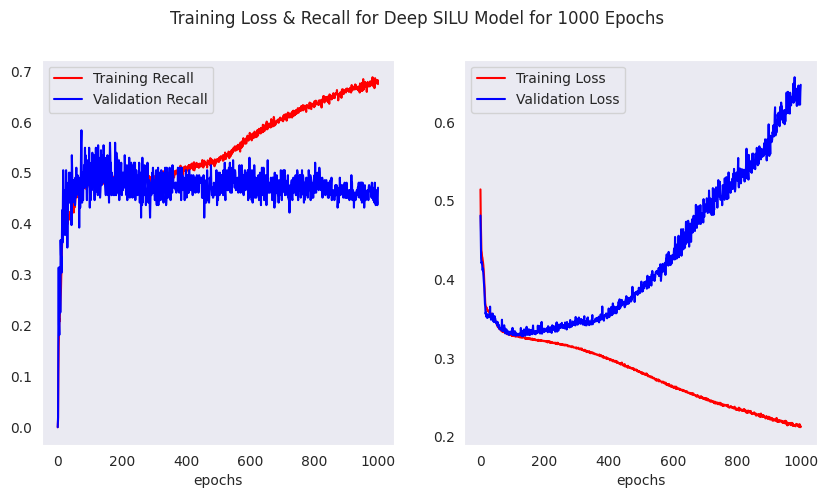

In [137]:
plot_history(deep_silu_model_history, 'Deep SILU Model for 1000 Epochs')

## Final Model

In [ ]:
def final_model_elu():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='elu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [ ]:
%%time

# Training model over 10000 epochs.

final_model_1 = final_model_elu()
final_model_1_history = final_model_1.fit(X_train, y_train, epochs=10000, batch_size=64, validation_data=(X_val, y_val), verbose=0)

Streaming output truncated to the last 5000 lines.
Epoch 7502/10000
125/125 - 0s - 2ms/step - accuracy: 0.8495 - loss: 0.3646 - val_accuracy: 0.8620 - val_loss: 0.3416
Epoch 7503/10000
125/125 - 0s - 2ms/step - accuracy: 0.8476 - loss: 0.3693 - val_accuracy: 0.8620 - val_loss: 0.3424
Epoch 7504/10000
125/125 - 0s - 2ms/step - accuracy: 0.8496 - loss: 0.3694 - val_accuracy: 0.8630 - val_loss: 0.3427
Epoch 7505/10000
125/125 - 0s - 2ms/step - accuracy: 0.8493 - loss: 0.3691 - val_accuracy: 0.8620 - val_loss: 0.3420
Epoch 7506/10000
125/125 - 0s - 2ms/step - accuracy: 0.8510 - loss: 0.3603 - val_accuracy: 0.8630 - val_loss: 0.3426
Epoch 7507/10000
125/125 - 0s - 2ms/step - accuracy: 0.8506 - loss: 0.3637 - val_accuracy: 0.8630 - val_loss: 0.3413
Epoch 7508/10000
125/125 - 0s - 2ms/step - accuracy: 0.8535 - loss: 0.3630 - val_accuracy: 0.8630 - val_loss: 0.3426
Epoch 7509/10000
125/125 - 0s - 2ms/step - accuracy: 0.8494 - loss: 0.3672 - val_accuracy: 0.8610 - val_loss: 0.3412
Epoch 7510/10

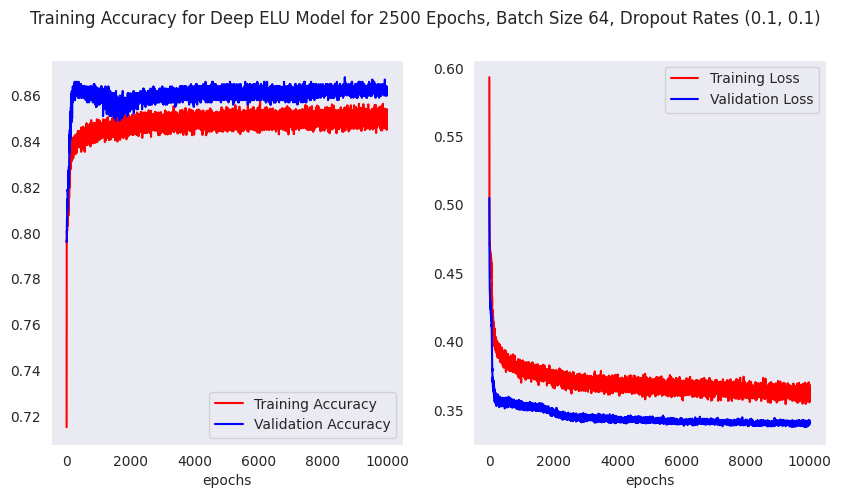

In [ ]:
plot_history(final_model_1_history, 'Deep ELU Model for 2500 Epochs, Batch Size 64, Dropout Rates (0.1, 0.1)')

In [ ]:
def final_model_silu():

  # Determining model architecture
  model = tf.keras.models.Sequential([
      tf.keras.Input((10,)),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(16, activation='silu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  # Compiling model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
      loss='binary_crossentropy',
      metrics=['recall'])

  return model

In [ ]:
%%time

# Training model over 10000 epochs.

final_model_2 = final_model_silu()
final_model_2_history = final_model_2.fit(X_train, y_train, epochs=10000, batch_size=64, validation_data=(X_val, y_val), verbose=0)

Streaming output truncated to the last 5000 lines.
Epoch 7502/10000
125/125 - 0s - 2ms/step - accuracy: 0.8535 - loss: 0.3534 - val_accuracy: 0.8660 - val_loss: 0.3419
Epoch 7503/10000
125/125 - 0s - 2ms/step - accuracy: 0.8505 - loss: 0.3581 - val_accuracy: 0.8660 - val_loss: 0.3412
Epoch 7504/10000
125/125 - 0s - 2ms/step - accuracy: 0.8495 - loss: 0.3582 - val_accuracy: 0.8670 - val_loss: 0.3422
Epoch 7505/10000
125/125 - 0s - 2ms/step - accuracy: 0.8558 - loss: 0.3551 - val_accuracy: 0.8630 - val_loss: 0.3396
Epoch 7506/10000
125/125 - 0s - 2ms/step - accuracy: 0.8496 - loss: 0.3612 - val_accuracy: 0.8640 - val_loss: 0.3413
Epoch 7507/10000
125/125 - 0s - 2ms/step - accuracy: 0.8550 - loss: 0.3516 - val_accuracy: 0.8670 - val_loss: 0.3415
Epoch 7508/10000
125/125 - 0s - 2ms/step - accuracy: 0.8565 - loss: 0.3534 - val_accuracy: 0.8670 - val_loss: 0.3418
Epoch 7509/10000
125/125 - 0s - 2ms/step - accuracy: 0.8541 - loss: 0.3524 - val_accuracy: 0.8670 - val_loss: 0.3422
Epoch 7510/10

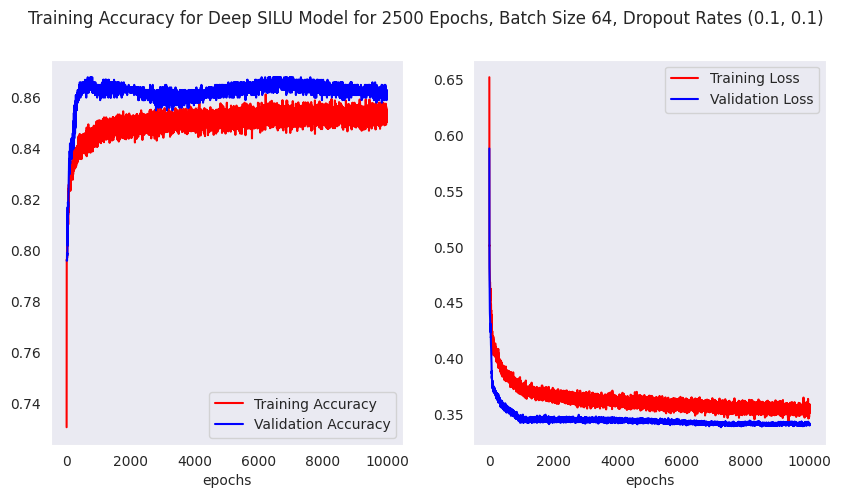

In [ ]:
plot_history(final_model_2_history, 'Deep SILU Model for 2500 Epochs, Batch Size 64, Dropout Rates (0.1, 0.1)')

In [ ]:
import tensorflow as tf

# Saving the models.

final_model_1.save("final_model_1.keras")
final_model_2.save("final_model_2.keras")

# Conclusion

This allows us to compare our final results. Let's run the models on the test data.

In [53]:
# Loading the saved models.

loaded_model_1 = tf.keras.models.load_model("banking_churn/final_model_1.keras")
loaded_model_2 = tf.keras.models.load_model("banking_churn/final_model_2.keras")

In [56]:
# Examining accuracies of all models.

print(f'Decision Tree Test Score: {final_tree.score(X_test, y_test):.4f}')
print(f'Random Forest Test Score: {final_forest.score(X_test, y_test):.4f}')
print(f'Neural Network Test Score: {loaded_model_1.evaluate(X_test, y_test)}')
print(f'Neural Network Test Score: {loaded_model_2.evaluate(X_test, y_test)}')

Decision Tree Test Score: 0.8260
Random Forest Test Score: 0.8620


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_15" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 12)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 12), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# Examining precisions of all models.

print(f'Decision Tree Precision: {precision_score(y_test, final_tree.predict(X_test)):.4f}')
print(f'Random Forest Precision: {precision_score(y_test, final_forest.predict(X_test)):.4f}')
print(f'Neural Network 1 Precision: {precision_score(y_test, np.round(loaded_model_1.predict(X_test))):.4f}')
print(f'Neural Network 2 Precision: {precision_score(y_test, np.round(loaded_model_2.predict(X_test))):.4f}')

Decision Tree Precision: 0.7851
Random Forest Precision: 0.8364
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Neural Network 1 Precision: 0.7723
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network 2 Precision: 0.8333


In [ ]:
# Examining recalls of all models.

print(f'Decision Tree Recall: {recall_score(y_test, final_tree.predict(X_test)):.4f}')
print(f'Random Forest Recall: {recall_score(y_test, final_forest.predict(X_test)):.4f}')
print(f'Neural Network 1 Recall: {recall_score(y_test, np.round(loaded_model_1.predict(X_test))):.4f}')
print(f'Neural Network 2 Recall: {recall_score(y_test, np.round(loaded_model_2.predict(X_test))):.4f}')

Decision Tree Recall: 0.4657
Random Forest Recall: 0.4510
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 1 Recall: 0.3824
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 2 Recall: 0.3186


In [ ]:
# Examining F1-scores of all models.

print(f'Decision Tree F1-Score: {f1_score(y_test, final_tree.predict(X_test)):.4f}')
print(f'Random Forest F1-Score: {f1_score(y_test, final_forest.predict(X_test)):.4f}')
print(f'Neural Network 1 F1-Score: {f1_score(y_test, np.round(loaded_model_1.predict(X_test))):.4f}')
print(f'Neural Network 2 F1-Score: {f1_score(y_test, np.round(loaded_model_2.predict(X_test))):.4f}')

Decision Tree F-Score: 0.5846
Random Forest F-Score: 0.5860
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 1 F-Score: 0.5115
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 2 F-Score: 0.4610


In [ ]:
# Examining ROC-AUCs of all models.

print(f'Decision Tree ROC-AUC: {roc_auc_score(y_test, final_tree.predict(X_test)):.4f}')
print(f'Random Forest ROC-AUC: {roc_auc_score(y_test, final_forest.predict(X_test)):.4f}')
print(f'Neural Network 1 ROC-AUC: {roc_auc_score(y_test, loaded_model_1.predict(X_test)):.4f}')
print(f'Neural Network 2 ROC-AUC: {roc_auc_score(y_test, loaded_model_2.predict(X_test)):.4f}')

Decision Tree ROC-AUC: 0.7165
Random Forest ROC-AUC: 0.7142
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 1 ROC-AUC: 0.8584
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Neural Network 2 ROC-AUC: 0.8493


## Model Comparison

|Model|Training Score|Validation Score|Test Score|Precision|Recall|F-Score|ROC-AUC|
|-|-|-|-|-|-|-|-|
|Decision Tree Classifier|0.853|0.855|0.865|0.785|0.466|0.585|0.717|
|Random Forest Classifier|0.880|0.866|0.870|0.836|0.451|0.586|0.714|
|Neural Network with ELU|0.850|0.860|0.860|0.772|0.382|0.512|0.858|
|Neural Network with SILU|0.854|0.860|0.855|0.833|0.319|0.461|0.849|

## Final Comments

Given the final results available, there are some remarks to be made on all of them.

- All four have very similar test scores of 0.855-0.870
- The precision for Random Forest and SILU models are noticeably higher at 0.83
- The recall for Decision Tree and Random Forest models are best
- The Random Forest consequently boasts the best F1-Score, marginally beating out the Decision Tree model
- The ELU model has the best ROC-AUC score

Given that the data is imbalanced between churn and not-churn (there are four times as many not-churn customers), it would be more feasible to prioritize the F1 score over the ROC-AUC score. In this instance, identifying a churning customer correctly is highly useful for the business. A customer in danger of churn may be reached out to and offered alternative options to alleviate their financial circumstances or to make the bank more attractive. The cost of reaching out to a customer *not* at risk of churn is quite low - the customer will most likely just ignore the call/email from the bank. Failling to identify a customer at risk of churn can be financially exacting upon the business.

As a result, it would be preferable to have a higher recall (to capture as many at risk of churn) than to have a higher precision. The Decision Tree model has the best recall and boasts a nearly-identical F1 score as the Random Forest. It also has the second-highest test score, beating both of the neural network models.

Therefore the Decision Tree model is our final choice.